In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay,roc_curve, auc, roc_auc_score, f1_score, recall_score, precision_score,precision_recall_curve
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_validate
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import VotingClassifier, StackingClassifier
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices
from sklearn.feature_selection import SelectKBest, f_classif
from IPython.display import display
RANDOM_STATE = 42

### Labels in Dataset
- Gender: 1-women, 2-men
- Cholesterol: 1:normal, 2:above normal, 3:well above normal 
- Glucose: 1: normal, 2: above normal, 3: well above normal 
- Smoke: 0: non smoker, 1: smoker


## Importing dataset
Used dataset from Kaggle: cardio_train.csv
- https://www.kaggle.com/datasets/sulianova/cardiovascular-disease-dataset

In [4]:
df = pd.read_csv("cardio_train.csv", sep=';')
df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


### Initial Cleanup - Removing Duplicate Records

In [6]:
df.drop('id', axis=1, inplace=True)
df.drop_duplicates(inplace=True)

### Splitting the Dataset
- target: 'cardio' is the target column.
- features: Contains all column names except the target column.
- 20% of the data is reserved for testing.

In [8]:
target = 'cardio'
features = df.columns.drop(target)

df_train, df_test = train_test_split(
    df,
    test_size=0.20,
    random_state=RANDOM_STATE,
    stratify=df[target]
)

X_train = df_train[features]
y_train = df_train[target]
X_test  = df_test[features]
y_test  = df_test[target]

In [9]:
df_train.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
29026,16028,1,154,44.0,110,70,1,1,0,0,1,0
22075,19055,1,167,63.0,14,90,2,1,0,0,1,0
32733,21129,2,164,70.0,70,100,1,1,0,0,0,0
21322,19770,2,171,92.0,150,100,3,3,0,0,0,1
63145,21908,1,165,75.0,140,90,1,1,0,0,1,0


### Transforming Age from Days to Years (both train and test data)
The `age` column is currently recorded in days, which can be difficult to interpret directly. 
To improve readability and usability, we convert age from days to years by dividing the values by 365.

In [11]:
df_train['age'] = df_train['age'] / 365
df_test['age'] = df_test['age'] / 365

In [12]:
df_train.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
29026,43.912329,1,154,44.0,110,70,1,1,0,0,1,0
22075,52.205479,1,167,63.0,14,90,2,1,0,0,1,0
32733,57.887671,2,164,70.0,70,100,1,1,0,0,0,0
21322,54.164384,2,171,92.0,150,100,3,3,0,0,0,1
63145,60.021918,1,165,75.0,140,90,1,1,0,0,1,0


### Converting Age and Weight columns to Integers (both train and test data)
We do not need age in decimal as integer data types necessary for modeling and analysis ease. 

In [14]:
df_train = df_train.astype({'age': 'int', 'weight': 'int'})
df_test = df_test.astype({'age': 'int', 'weight': 'int'})

In [15]:
df_train.shape

(55980, 12)

In [16]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 55980 entries, 29026 to 46063
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   age          55980 non-null  int64
 1   gender       55980 non-null  int64
 2   height       55980 non-null  int64
 3   weight       55980 non-null  int64
 4   ap_hi        55980 non-null  int64
 5   ap_lo        55980 non-null  int64
 6   cholesterol  55980 non-null  int64
 7   gluc         55980 non-null  int64
 8   smoke        55980 non-null  int64
 9   alco         55980 non-null  int64
 10  active       55980 non-null  int64
 11  cardio       55980 non-null  int64
dtypes: int64(12)
memory usage: 5.6 MB


### Checking for missing values in the Dataset
Total number of missing values for each columns shows 0 which is ideal. 

In [18]:
df_train.isna().sum()

age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
dtype: int64

### Analyzing correlations between features
Examining relationships between different numeric features in our dataset.

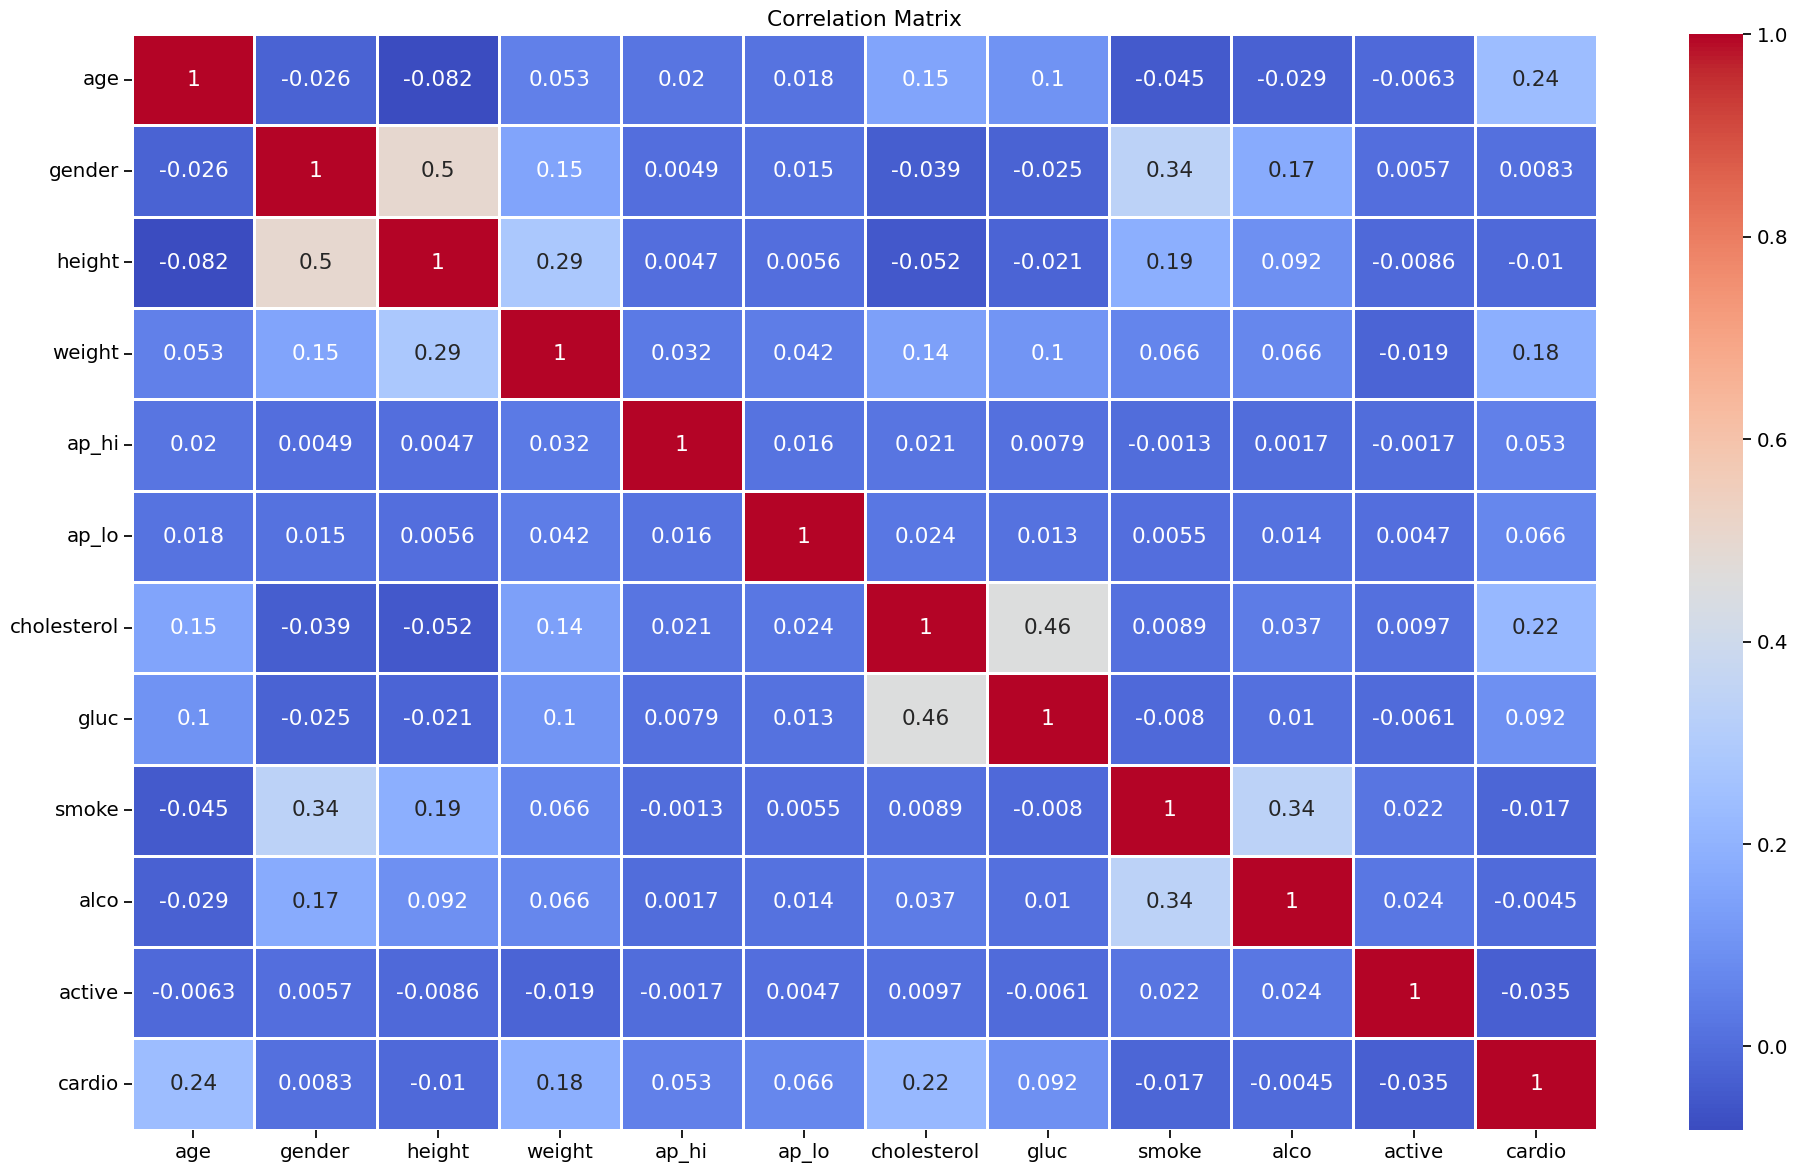

In [20]:
# Analyze correlations between features
plt.figure(figsize=(20, 12))
sns.set_context('notebook', font_scale=1.3)
sns.heatmap(df_train.corr(), annot=True, linewidths=2, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

In [21]:
df.describe()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000
mean,19468.950126,1.349648,164.359152,74.208519,128.820453,96.636261,1.366997,1.226535,0.088159,0.053790,0.803718,0.499771
std,2467.374620,0.476862,8.211218,14.397211,154.037729,188.504581,0.680333,0.572353,0.283528,0.225604,0.397187,0.500004
min,10798.000000,1.000000,55.000000,10.000000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,17664.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,19703.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,21327.000000,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,23713.000000,2.000000,250.000000,200.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


### Exploratory Data Analysis: Box Plot of Height
Trying to understand the distribution of the 'height' variable and identifying any outliers. We can spot some Height upto 250cm. 

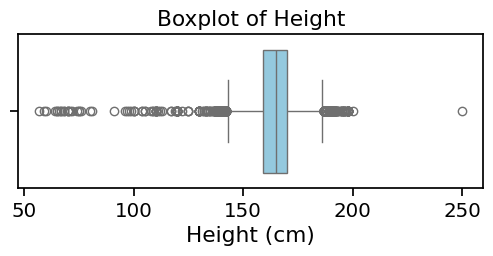

In [23]:
plt.figure(figsize=(6, 2))
sns.boxplot(x=df_train['height'], color='skyblue')
plt.title('Boxplot of Height')
plt.xlabel('Height (cm)')
plt.show()


### Exploratory Data Analysis: Distribution of Height
Exploring the shape of the data to check for skewness, central tendency and spread. 

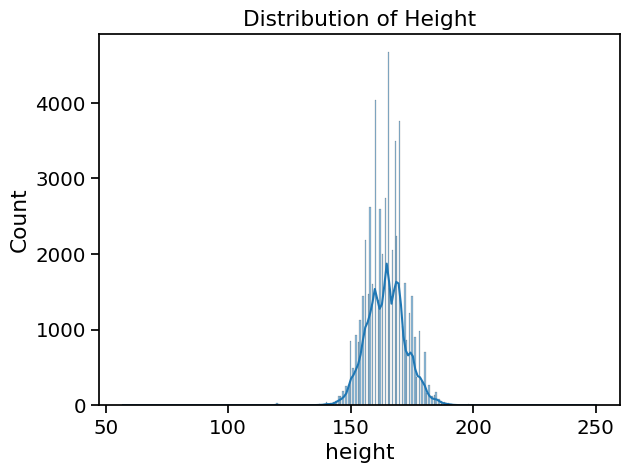

In [25]:
# Height visualization
plt.figure(figsize=(12, 5))


# Histogram
plt.subplot(1, 2, 2)
sns.histplot(df_train['height'], kde=True)
plt.title('Distribution of Height')

plt.tight_layout()
plt.show()

### Exploratory Data Analysis: Box Plot of Weight
Trying to understand the distribution of the 'weight' variable and identifying any outliers. We can spot some Weight upto 200kg. 

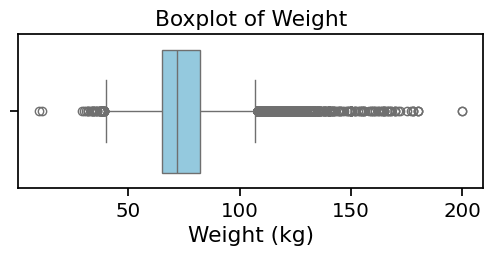

In [27]:
plt.figure(figsize=(6, 2))
sns.boxplot(x=df_train['weight'], color='skyblue')
plt.title('Boxplot of Weight')
plt.xlabel('Weight (kg)')
plt.show()


### Exploratory Data Analysis: Distribution of Weight
Exploring the shape of the data to check for skewness, central tendency and spread. 

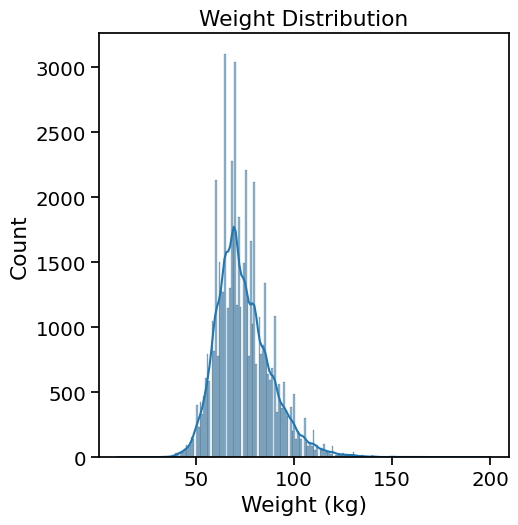

In [29]:
plt.figure(figsize=(15, 10))
plt.subplot(2, 3, 2)
sns.histplot(df_train['weight'], kde=True)
plt.title('Weight Distribution')
plt.xlabel('Weight (kg)')
plt.tight_layout()
plt.show()

### Exploratory Data Analysis: Box Plot of Systolic Blood Pressure (ap_hi)
Trying to understand the distribution of the 'ap_hi' variable and identifying any outliers. We can spot some Systolic BP to be greater than 15000 mmHg. 

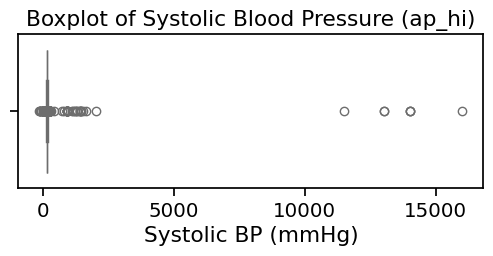

In [31]:
plt.figure(figsize=(6, 2))
sns.boxplot(x=df_train['ap_hi'], color='salmon')
plt.title('Boxplot of Systolic Blood Pressure (ap_hi)')
plt.xlabel('Systolic BP (mmHg)')
plt.show()


### Exploratory Data Analysis: Box Plot of Diastolic Blood Pressure (ap_lo)
Trying to understand the distribution of the 'ap_lo' variable and identifying any outliers. We can spot some Diastolic BP to be greater than 10000 mmHg. 

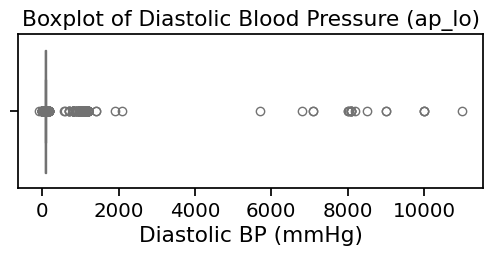

In [33]:
plt.figure(figsize=(6, 2))
sns.boxplot(x=df_train['ap_lo'], color='plum')
plt.title('Boxplot of Diastolic Blood Pressure (ap_lo)')
plt.xlabel('Diastolic BP (mmHg)')
plt.show()


###  Data Cleaning: Removing Outliers (both train and test datasets)
- Height includes values between 140 cm and 203 cm. 
- Weight includes values between 35 kg and 200 kg. 
- Calculating and Removing unrealistic BMI values. 
- Using AHA guidelines to remove unrealistic blood pressure values.

### BMI Calculation
We calculate the **Body Mass Index (BMI)** for each individual in the dataset using the standard BMI formula
- https://www.cdc.gov/bmi/adult-calculator/bmi-categories.html

In [35]:
# 1) Apply realistic blood preasue to df train:
df_train = df_train[
    (df_train['height'] >= 140) & (df_train['height'] <= 203) &
    (df_train['weight'] >= 35)  & (df_train['weight'] <= 200)
].copy()

# compute BMI and filter extremes
df_train['BMI'] = df_train['weight'] / ((df_train['height'] / 100) ** 2)
df_train = df_train[(df_train['BMI'] >= 15) & (df_train['BMI'] <= 60)]

# filter blood pressure
df_train = df_train[
    (df_train['ap_hi'] >= 70)  & (df_train['ap_hi'] <= 250) &
    (df_train['ap_lo'] >= 40)  & (df_train['ap_lo'] <= 150) &
    (df_train['ap_lo'] < df_train['ap_hi'])
]

# 2) Apply to df_test:
df_test = df_test[
    (df_test['height'] >= 140) & (df_test['height'] <= 203) &
    (df_test['weight'] >= 35)  & (df_test['weight'] <= 200)
].copy()

df_test['BMI'] = df_test['weight'] / ((df_test['height'] / 100) ** 2)
df_test = df_test[(df_test['BMI'] >= 15) & (df_test['BMI'] <= 60)]

df_test = df_test[
    (df_test['ap_hi'] >= 70)  & (df_test['ap_hi'] <= 250) &
    (df_test['ap_lo'] >= 40)  & (df_test['ap_lo'] <= 150) &
    (df_test['ap_lo'] < df_test['ap_hi'])
]


In [36]:
# Print the shape of the cleaned dataset
print(f"Original dataset shape: {70000}")
print(f"Cleaned dataset shape: {df.shape[0]}")
print(f"Number of records removed: {70000 - df.shape[0]}")

Original dataset shape: 70000
Cleaned dataset shape: 69976
Number of records removed: 24


### Distribution of BMI
Exploring the shape of the data to check for skewness, central tendency and spread. The data appears to be left-skewed.  

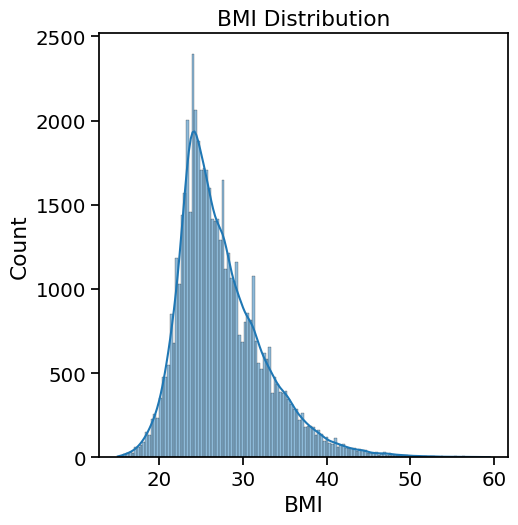

In [38]:
plt.figure(figsize=(15, 10))
plt.subplot(2, 3, 3)
sns.histplot(df_train['BMI'], kde=True)
plt.title('BMI Distribution')
plt.xlabel('BMI')
plt.tight_layout()

fig = plt.gcf()
fig.savefig("bmi_distribution.png", dpi=300, bbox_inches="tight")

plt.show()

### Distribution of Systolic Blood Pressure

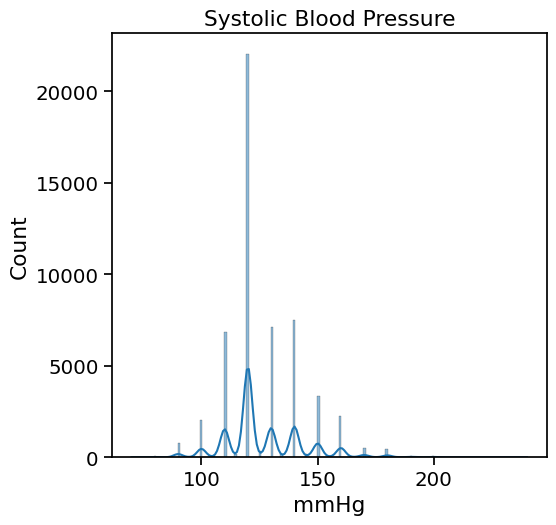

In [40]:
plt.figure(figsize=(15, 10))
# Plot 4: Systolic BP Distribution
plt.subplot(2, 3, 4)
sns.histplot(df_train['ap_hi'], kde=True)
plt.title('Systolic Blood Pressure')
plt.xlabel('mmHg')
plt.tight_layout()
plt.show()

### Distribution of Diastolic Blood Pressure

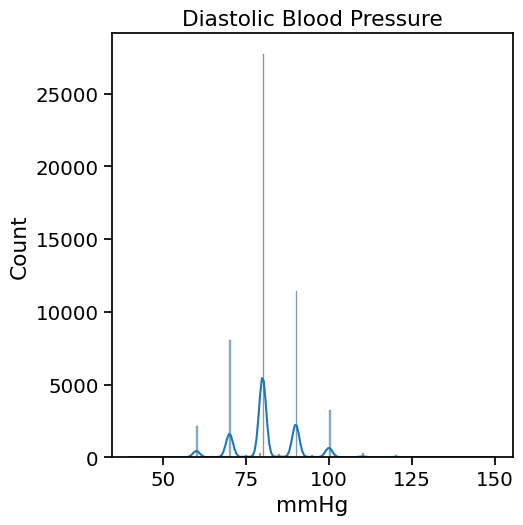

In [42]:
plt.figure(figsize=(15, 10))
# Plot 5: Diastolic BP Distribution
plt.subplot(2, 3, 5)
sns.histplot(df_train['ap_lo'], kde=True)
plt.title('Diastolic Blood Pressure')
plt.xlabel('mmHg')
plt.tight_layout()
plt.show()

### Target Variable Analysis: Cardiovascular Disease Presence
To understand the distribution of the target variable `cardio`, we visualize both the **absolute counts** and the **percentage breakdown** of cases in the dataset with help of bar chart and pie chart. 

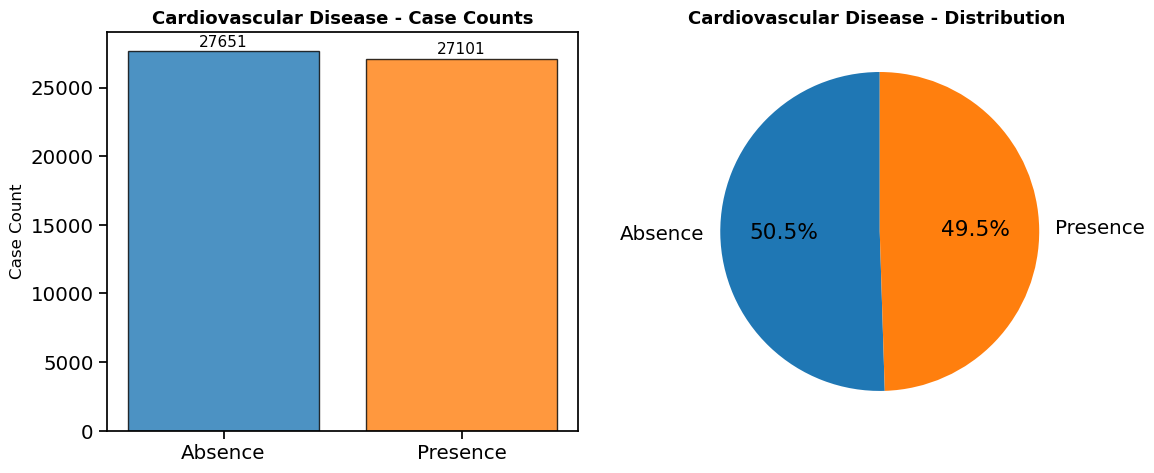

In [44]:
# Cardiovascular disease counts
cardio_counts = df_train["cardio"].value_counts().sort_index()

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# ----- Bar Chart with Counts -----
ax_bar = axes[0]
colors = ["#1f77b4", "#ff7f0e"]
ax_bar.bar([0, 1], cardio_counts, edgecolor="black", alpha=0.8, color=colors)
ax_bar.set_xticks([0, 1])
ax_bar.set_xticklabels(["Absence", "Presence"])

# Place count labels on top of bars
for i, count in enumerate(cardio_counts):
    ax_bar.text(i, count + 100, f"{count}", ha="center", va="bottom", fontsize=11)

ax_bar.set_ylabel("Case Count", fontsize=12)
ax_bar.set_title("Cardiovascular Disease - Case Counts", fontsize=13, fontweight="bold")

# ----- Pie Chart with Percentages -----
ax_pie = axes[1]
labels = ["Absence", "Presence"]
ax_pie.pie(cardio_counts.values, labels=labels, autopct='%1.1f%%',
           startangle=90, colors=colors)
ax_pie.set_title("Cardiovascular Disease - Distribution ", fontsize=13, fontweight="bold")

plt.tight_layout()
fig.savefig("cardio_distribution.png", dpi=300, bbox_inches="tight")
plt.show()


<Axes: xlabel='cardio', ylabel='cholesterol'>

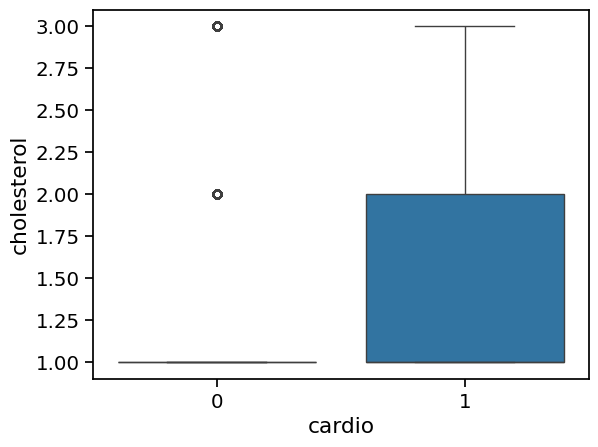

In [45]:
sns.boxplot(x="cardio", y="cholesterol", data=df_train)


In [46]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 54752 entries, 29026 to 46063
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          54752 non-null  int64  
 1   gender       54752 non-null  int64  
 2   height       54752 non-null  int64  
 3   weight       54752 non-null  int64  
 4   ap_hi        54752 non-null  int64  
 5   ap_lo        54752 non-null  int64  
 6   cholesterol  54752 non-null  int64  
 7   gluc         54752 non-null  int64  
 8   smoke        54752 non-null  int64  
 9   alco         54752 non-null  int64  
 10  active       54752 non-null  int64  
 11  cardio       54752 non-null  int64  
 12  BMI          54752 non-null  float64
dtypes: float64(1), int64(12)
memory usage: 5.8 MB


df_train = df_train.astype({'BMI': 'int'})
df_test = df_test.astype({'BMI': 'int'})

In [48]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 54752 entries, 29026 to 46063
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          54752 non-null  int64  
 1   gender       54752 non-null  int64  
 2   height       54752 non-null  int64  
 3   weight       54752 non-null  int64  
 4   ap_hi        54752 non-null  int64  
 5   ap_lo        54752 non-null  int64  
 6   cholesterol  54752 non-null  int64  
 7   gluc         54752 non-null  int64  
 8   smoke        54752 non-null  int64  
 9   alco         54752 non-null  int64  
 10  active       54752 non-null  int64  
 11  cardio       54752 non-null  int64  
 12  BMI          54752 non-null  float64
dtypes: float64(1), int64(12)
memory usage: 5.8 MB


### Smoking Status Distribution
Calculating **percentage distribution** of values in the 'smoke' column to understand how smoking behavior is represented in the dataset. 
- 0: non-smoker
- 1: smoker

In [50]:
df_train['smoke'].value_counts(normalize=True) * 100

smoke
0    91.225891
1     8.774109
Name: proportion, dtype: float64

### Gender Distribution Analysis
Examining how gender is represented.
- 1 represent women
- 2 represent men

In [52]:
df_train['gender'].value_counts(normalize=True) * 100

gender
1    65.254237
2    34.745763
Name: proportion, dtype: float64

In [53]:
df_train.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,BMI
29026,43,1,154,44,110,70,1,1,0,0,1,0,18.552876
21322,54,2,171,92,150,100,3,3,0,0,0,1,31.462672
63145,60,1,165,75,140,90,1,1,0,0,1,0,27.548209
62922,47,2,160,85,150,80,1,1,1,0,1,1,33.203125
29205,58,2,165,65,120,70,1,1,0,0,0,1,23.875115


### BMI Categorization 
To enhance interpretability of the BMI values, we classify individuals into standard **BMI categories** based on medical guidelines.

In [55]:
def classify_bmi(BMI):
    if BMI < 18.5:
        return "Underweight"
    elif BMI < 25:
        return "Healthy Weight"
    elif BMI < 30:
        return "Overweight"
    elif BMI < 35:
        return "Obese Class I"
    elif BMI < 40:
        return "Obese Class II"
    else:
        return "Obese Class III"

df_train["BMI_category"] = df_train["BMI"].apply(classify_bmi)
df_test["BMI_category"] = df_test["BMI"].apply(classify_bmi)
df_train.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,BMI,BMI_category
29026,43,1,154,44,110,70,1,1,0,0,1,0,18.552876,Healthy Weight
21322,54,2,171,92,150,100,3,3,0,0,0,1,31.462672,Obese Class I
63145,60,1,165,75,140,90,1,1,0,0,1,0,27.548209,Overweight
62922,47,2,160,85,150,80,1,1,1,0,1,1,33.203125,Obese Class I
29205,58,2,165,65,120,70,1,1,0,0,0,1,23.875115,Healthy Weight


### Pulse Pressure Calculation & Categorization
We compute a new cardiovascular health indicator called **Pulse Pressure**, which is the difference between systolic and diastolic blood pressure.

### Resources 
- https://www.mayoclinic.org/diseases-conditions/high-blood-pressure/expert-answers/pulse-pressure/faq-20058189
- https://www.heart.org/en/health-topics/high-blood-pressure/understanding-blood-pressure-readings

In [57]:
df_train["Pulse_Pressure"] = df_train["ap_hi"] - df_train["ap_lo"]
df_test["Pulse_Pressure"] = df_test["ap_hi"] - df_test["ap_lo"]


def categorize_pulse_pressure(pp):
    if pp < 40:
        return "Below Normal"
    elif pp <= 40:
        return "Healthy"
    elif pp <= 60:
        return "Unhealthy"
    else:
        return "High Risk"

df_train["Pulse_Preasure_Category"] = df_train["Pulse_Pressure"].apply(categorize_pulse_pressure)
df_test["Pulse_Preasure_Category"] = df_test["Pulse_Pressure"].apply(categorize_pulse_pressure)
df_train.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,BMI,BMI_category,Pulse_Pressure,Pulse_Preasure_Category
29026,43,1,154,44,110,70,1,1,0,0,1,0,18.552876,Healthy Weight,40,Healthy
21322,54,2,171,92,150,100,3,3,0,0,0,1,31.462672,Obese Class I,50,Unhealthy
63145,60,1,165,75,140,90,1,1,0,0,1,0,27.548209,Overweight,50,Unhealthy
62922,47,2,160,85,150,80,1,1,1,0,1,1,33.203125,Obese Class I,70,High Risk
29205,58,2,165,65,120,70,1,1,0,0,0,1,23.875115,Healthy Weight,50,Unhealthy


### Blood Pressure Classification 
We categorized individuals into **blood pressure risk groups** using systolic (`ap_hi`) and diastolic (`ap_lo`) measurements based on **clinical guidelines from the American Heart Association (AHA)**
- Normal Blood Pressure: sbp < 120 and dbp < 80
- Elevated Blood Pressure: 120 <= sbp < 130 and dbp < 80
- High Blood Pressure (Hypertension) Stage 1: (130 <= sbp < 140) or (80 <= dbp < 90)
- High Blood Pressure (Hypertension) Stage 2: sbp >= 140 or dbp >= 90
- Hypertensive Crisis: sbp > 180 or dbp > 120

In [59]:
def classify_blood_pressure(sbp, dbp):
    if sbp < 120 and dbp < 80:
        return "Normal Blood Pressure"
    elif 120 <= sbp < 130 and dbp < 80:
        return "Elevated Blood Pressure"
    elif (130 <= sbp < 140) or (80 <= dbp < 90):
        return "High Blood Pressure (Hypertension) Stage 1"
    elif sbp >= 140 or dbp >= 90:
        return "High Blood Pressure (Hypertension) Stage 2"
    elif sbp > 180 or dbp > 120:
        return "Hypertensive Crisis"
    else:
        return "Unclassified"

# Apply the classification
df_train["Blood_Preasure_Category"] = df_train.apply(lambda row: classify_blood_pressure(row["ap_hi"], row["ap_lo"]), axis=1)
df_test["Blood_Preasure_Category"] = df_test.apply(lambda row: classify_blood_pressure(row["ap_hi"], row["ap_lo"]), axis=1)
df_train.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,BMI,BMI_category,Pulse_Pressure,Pulse_Preasure_Category,Blood_Preasure_Category
29026,43,1,154,44,110,70,1,1,0,0,1,0,18.552876,Healthy Weight,40,Healthy,Normal Blood Pressure
21322,54,2,171,92,150,100,3,3,0,0,0,1,31.462672,Obese Class I,50,Unhealthy,High Blood Pressure (Hypertension) Stage 2
63145,60,1,165,75,140,90,1,1,0,0,1,0,27.548209,Overweight,50,Unhealthy,High Blood Pressure (Hypertension) Stage 2
62922,47,2,160,85,150,80,1,1,1,0,1,1,33.203125,Obese Class I,70,High Risk,High Blood Pressure (Hypertension) Stage 1
29205,58,2,165,65,120,70,1,1,0,0,0,1,23.875115,Healthy Weight,50,Unhealthy,Elevated Blood Pressure


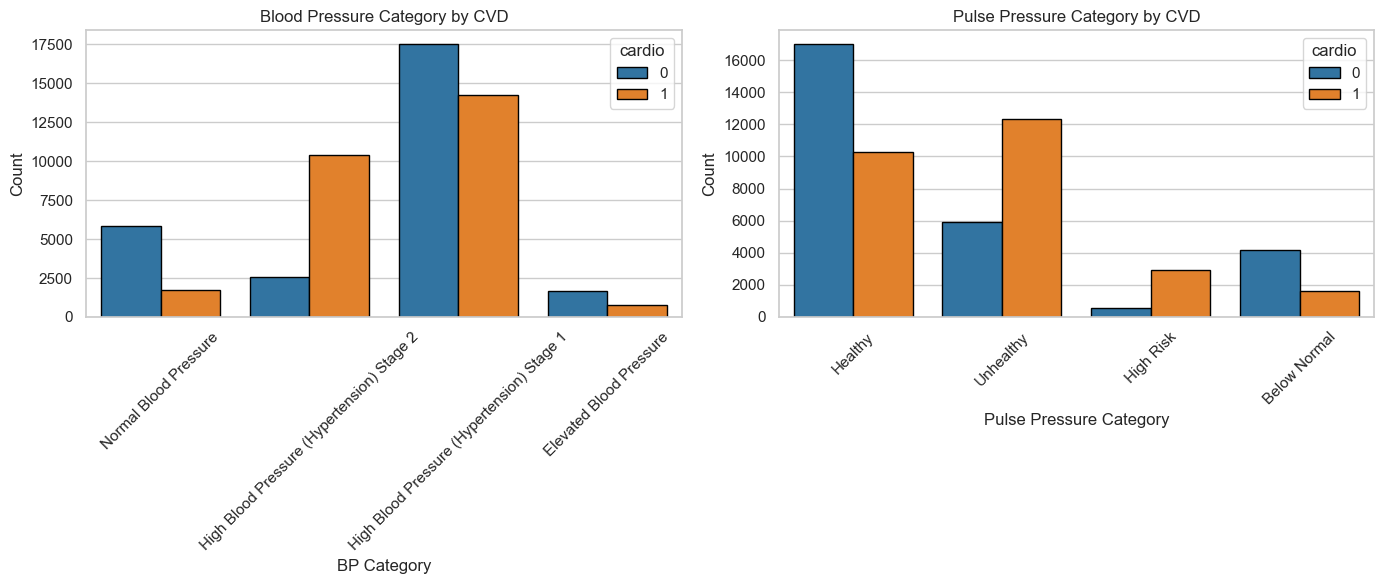

In [60]:
sns.set_theme(style="whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.countplot(
    data=df_train,
    x='Blood_Preasure_Category',
    hue='cardio',
    palette=['#1f77b4','#ff7f0e'],
    edgecolor='black',
    ax=axes[0]
)
axes[0].set_title("Blood Pressure Category by CVD")
axes[0].set_xlabel("BP Category")
axes[0].set_ylabel("Count")
axes[0].tick_params(axis='x', rotation=45)

sns.countplot(
    data=df_train,
    x='Pulse_Preasure_Category',
    hue='cardio',
    palette=['#1f77b4','#ff7f0e'],
    edgecolor='black',
    ax=axes[1]
)
axes[1].set_title("Pulse Pressure Category by CVD")
axes[1].set_xlabel("Pulse Pressure Category")
axes[1].set_ylabel("Count")
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
fig.savefig("bp_and_pp_vs_cardio.png", dpi=300, bbox_inches="tight")
plt.show()

### LifeStyle Risk Indicator 
We create a new binary feature called `lifestyle_risk` to identify individuals who **maintain a healthy lifestyle** based on three behaviors:
- Smoke == 0; Non-smoker
- Alcohol == 0; Does not consume alcohol
- Active == 1; Physically active.
If all three conditions are met, the individual is marked with 1 (low lifestyle risk) else 0 (higher risk)

In [62]:
df_train["lifestyle_risk"] = ((df_train['smoke'] == 0) & (df_train["alco"] == 0) & (df_train["active"] == 1)).astype(int)
df_test["lifestyle_risk"] = ((df_test['smoke'] == 0) & (df_test["alco"] == 0) & (df_test["active"] == 1)).astype(int)
df_train.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,BMI,BMI_category,Pulse_Pressure,Pulse_Preasure_Category,Blood_Preasure_Category,lifestyle_risk
29026,43,1,154,44,110,70,1,1,0,0,1,0,18.552876,Healthy Weight,40,Healthy,Normal Blood Pressure,1
21322,54,2,171,92,150,100,3,3,0,0,0,1,31.462672,Obese Class I,50,Unhealthy,High Blood Pressure (Hypertension) Stage 2,0
63145,60,1,165,75,140,90,1,1,0,0,1,0,27.548209,Overweight,50,Unhealthy,High Blood Pressure (Hypertension) Stage 2,1
62922,47,2,160,85,150,80,1,1,1,0,1,1,33.203125,Obese Class I,70,High Risk,High Blood Pressure (Hypertension) Stage 1,0
29205,58,2,165,65,120,70,1,1,0,0,0,1,23.875115,Healthy Weight,50,Unhealthy,Elevated Blood Pressure,0


### Smoking Habit Distribution 
This bar chart shows the distribution of individuals based on their smoking status using the `smoke` column. 

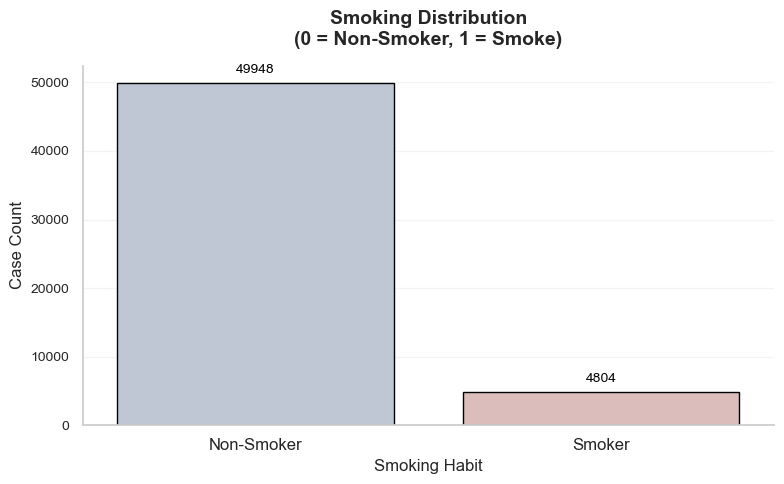

In [64]:
plt.figure(figsize=(8, 5))
ax = sns.countplot(x="smoke",
                   data=df_train,
                   hue="smoke",
                   palette="vlag",
                   edgecolor='black',
                   legend=False)  

for x in ax.containers:
    ax.bar_label(x,
                label_type='edge',
                color='black',
                fontsize=10,
                padding=5)

plt.title("Smoking Distribution\n(0 = Non-Smoker, 1 = Smoke)",
         fontsize=14,
         pad=15,
         fontweight='bold')
plt.xlabel("Smoking Habit", fontsize=12)
plt.ylabel("Case Count", fontsize=12)

plt.xticks([0, 1], ["Non-Smoker", "Smoker"], fontsize=12)
plt.yticks(fontsize=10)

sns.despine()
plt.grid(axis='y', alpha=0.2)
plt.tight_layout()
plt.show()


### Cardiovascular Disease by Age
Grouped bar chart shows how cardiovascular disease (`cardio`) is distributed across different `age` categories. 

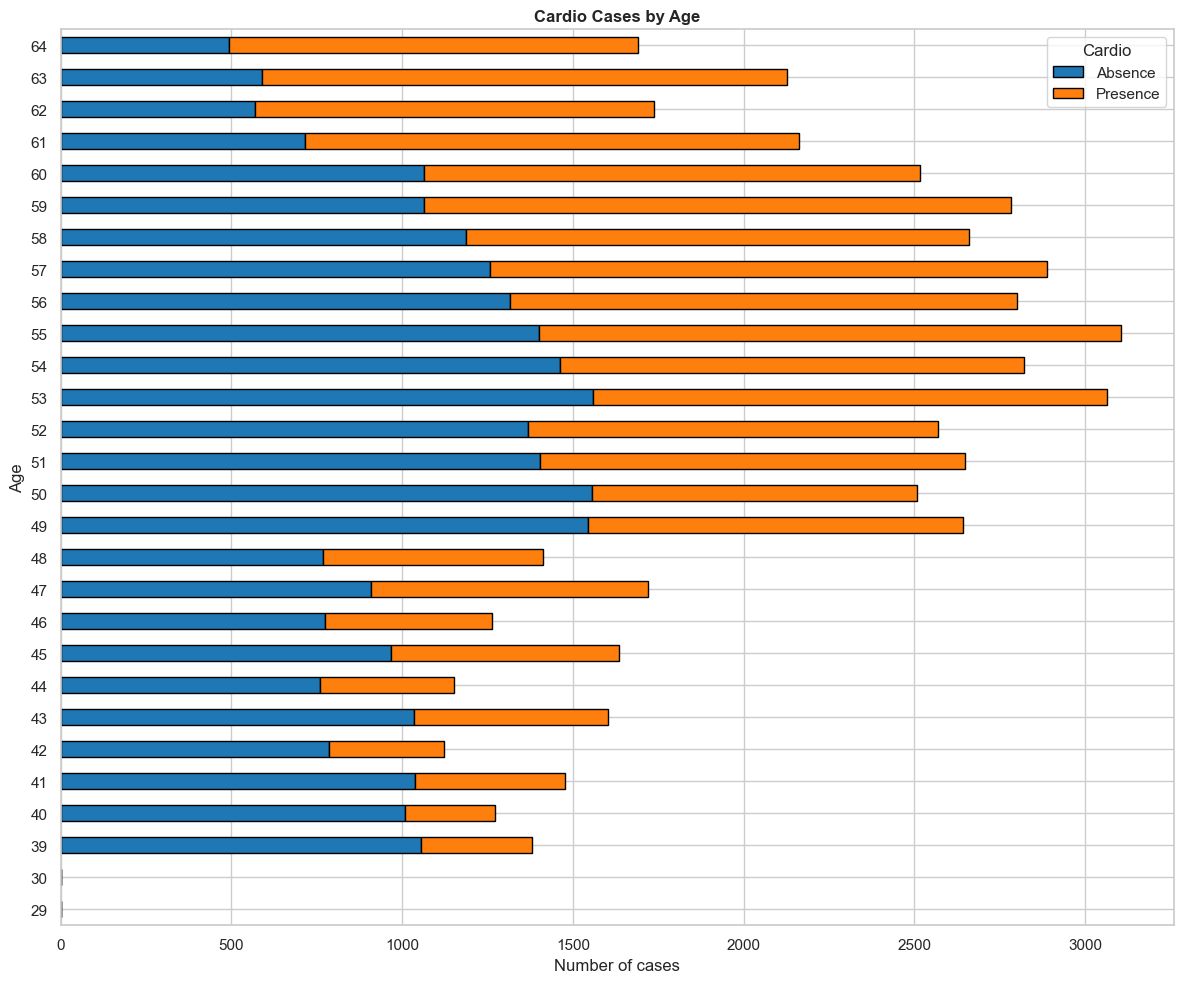

In [66]:
ct = df_train.groupby(['age','cardio']).size().unstack(fill_value=0)
ax = ct.plot(
    kind='barh',
    stacked=True,
    figsize=(12, 10),
    color=["#1f77b4","#ff7f0e"],
    edgecolor='black'
)
plt.legend(['Absence','Presence'], title='Cardio')
plt.xlabel("Number of cases")
plt.ylabel("Age")
plt.title("Cardio Cases by Age", fontweight='bold')
plt.tight_layout()

fig = ax.get_figure()       
fig.savefig("cardio_by_age.png", dpi=300, bbox_inches="tight")

plt.show()


### Cardiovascular Disease Distribution by Gender
Grouped bar chart visualizes the relationship between gender and cardiovascular disease (`cardio`) status.

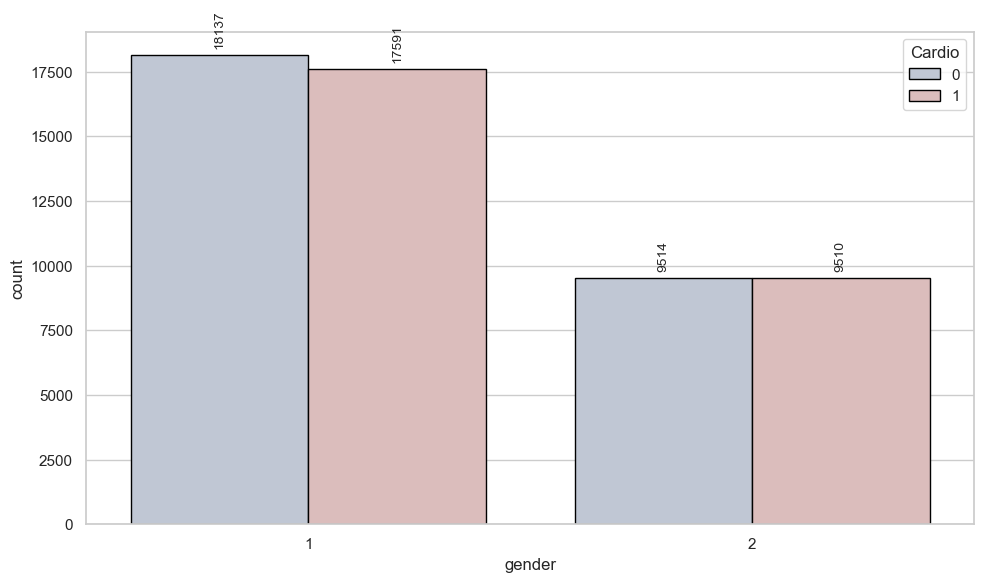

In [68]:
plt.figure(figsize=(10, 6))

ax = sns.countplot(
    data=df_train,
    x='gender',
    hue='cardio',
    palette='vlag',
    edgecolor='black'
)

for container in ax.containers:
    ax.bar_label(container, rotation=90, label_type='edge', fontsize=10, padding=5)


plt.legend(title='Cardio', loc='upper right')

plt.tight_layout()
plt.show()


### BMI Distribution by Age and Cardiovascular Status
The below boxplot illustrates how Body Mass Index (BMI) varies across different age and cardiovascular health status.

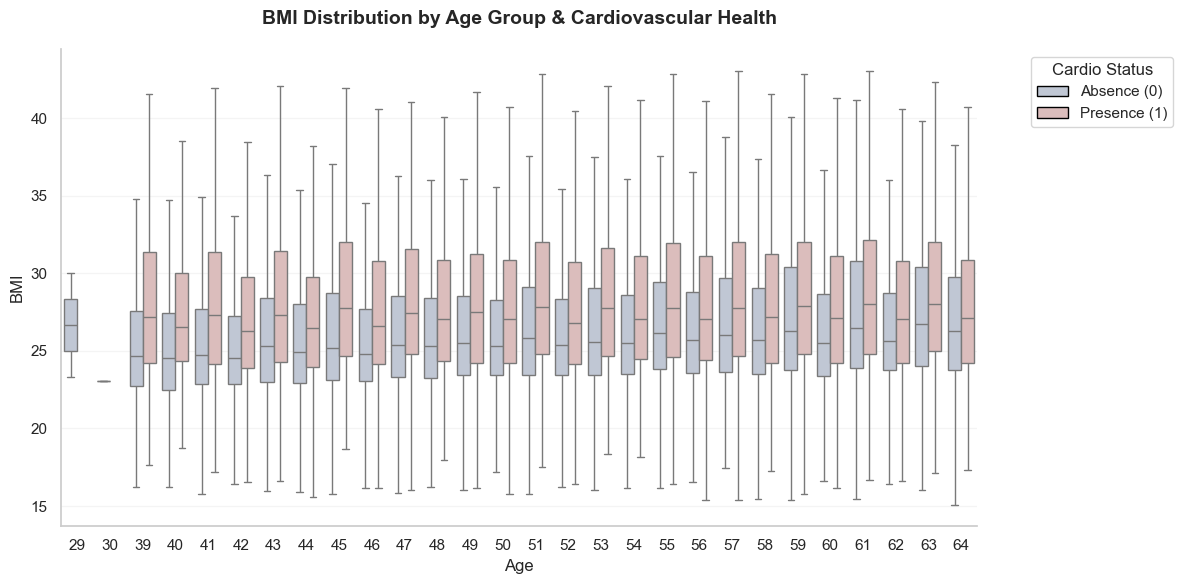

In [70]:
plt.figure(figsize=(12,6))
sns.boxplot(data=df_train, x='age', y='BMI', hue='cardio',
           palette='vlag', showfliers=False)

plt.title("BMI Distribution by Age Group & Cardiovascular Health",
         fontsize=14,
          pad=18,
          fontweight='bold')

plt.xlabel("Age", fontsize=12)
plt.ylabel("BMI", fontsize=12)

handles, _ = ax.get_legend_handles_labels()
plt.legend(handles, ['Absence (0)', 'Presence (1)'],
          title='Cardio Status',
          bbox_to_anchor=(1.05, 1),
          loc='upper left')


sns.despine()
plt.grid(axis='y', alpha=0.2)
plt.tight_layout()
plt.show()


### Multicollinearity Check using Correlation Matrix and VIF
To ensure the model's reliability, we are assess multicollinearity among independent features. 
- **Correlation Matrix** – to get a preliminary idea of linear relationships between numerical variables.
- **Variance Inflation Factor (VIF)** – to quantify how much the variance of a regression coefficient is inflated due to collinearity.

VIF values:
- VIF = 1: No multicollinearity.
- 1 < VIF < 5: Moderate correlation, usually acceptable.
- VIF ≥ 5: Potential multicollinearity concern.
- VIF > 10: Serious multicollinearity; consider removing the feature.

In [72]:
# Step 1: Check correlations
print(df_train[['age', 'BMI', 'Pulse_Pressure']].corr())

# Step 2: Calculate VIF for regression features
y, X = dmatrices('cardio ~ age + BMI + Pulse_Pressure', data=df_train, return_type='dataframe')
vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(dict(zip(X.columns, vif)))

                     age       BMI  Pulse_Pressure
age             1.000000  0.104516        0.173207
BMI             0.104516  1.000000        0.190550
Pulse_Pressure  0.173207  0.190550        1.000000
{'Intercept': 85.77332416479061, 'age': 1.0365994458693386, 'BMI': 1.0433853251216598, 'Pulse_Pressure': 1.0639056054930478}


### Result Analysis from Correlation matrix and VIF computation
- All feature correlations are relatively low, suggesting weak linear relationships.
- No pair exceeds 0.2, so initial signs of multicollinearity are minimal.

In [74]:
# df_train["cholesterol_bmi_interaction"] = df_train["cholesterol"] * df_train["BMI"]
# df_test["cholesterol_bmi_interaction"] = df_test["cholesterol"] * df_test["BMI"]
# df.head()

In [75]:
# # Calculate correlations
# corr_matrix = df_train[['BMI', 'cholesterol', 'cholesterol_bmi_interaction', 'cardio']].corr()

# # Plot heatmap
# plt.figure(figsize=(8,6))
# sns.heatmap(corr_matrix, annot=True, cmap='vlag', fmt='.2f',
#             mask=np.triu(np.ones_like(corr_matrix, dtype=bool)))
# plt.title("BMI-Cholesterol-Cardio Correlation", fontsize=14, pad=12)
# plt.show()

### Visualizing Cardiovascular Disease Prevalence by Age and Lifestyle Risk
The below heatmap shows the prevalence of cardiovascular disease (CVD) by age and lifestyle risk.
- For both lifestyle risk groups, CVD prevalence increases with age.
- At every age, individuals with lower lifestyle risk (column "1") tend to have similar or slightly lower prevalence compared to those with higher lifestyle risk (column "0").
- Age is a strong factor: CVD prevalence rises sharply with age.
- The overall trend is a steady increase in CVD prevalence from age 30 to 64, regardless of lifestyle risk category.

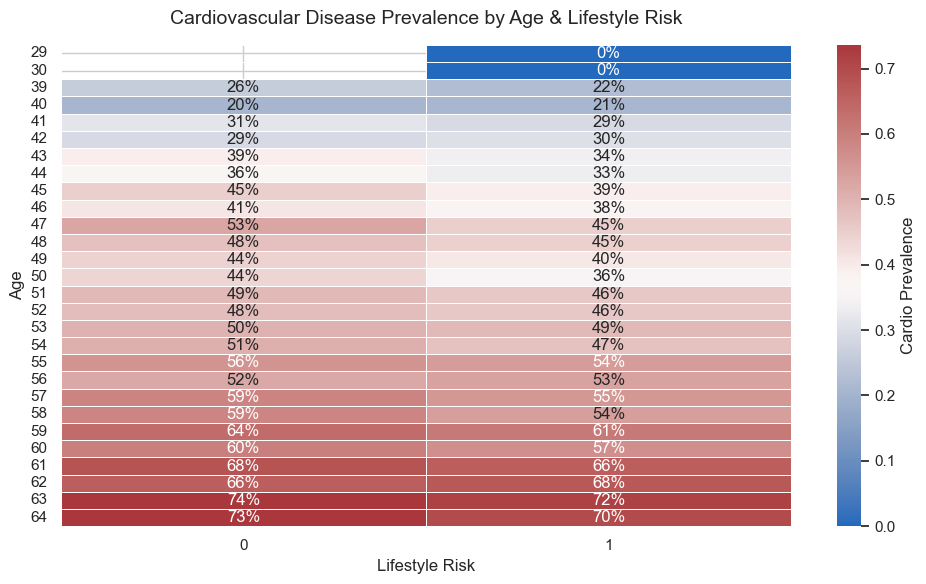

In [77]:
# Calculate cardio prevalence
heatmap_data = df_train.groupby(['age', 'lifestyle_risk'], observed=False)['cardio'].mean().unstack()

plt.figure(figsize=(10,6))
sns.heatmap(heatmap_data, annot=True, fmt='.0%', cmap='vlag',
           linewidths=0.5, cbar_kws={'label': 'Cardio Prevalence'})

plt.title("Cardiovascular Disease Prevalence by Age & Lifestyle Risk",
         fontsize=14, pad=15)
plt.xlabel("Lifestyle Risk", fontsize=12)
plt.ylabel("Age", fontsize=12)
plt.tight_layout()
plt.show()


In [78]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 54752 entries, 29026 to 46063
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   age                      54752 non-null  int64  
 1   gender                   54752 non-null  int64  
 2   height                   54752 non-null  int64  
 3   weight                   54752 non-null  int64  
 4   ap_hi                    54752 non-null  int64  
 5   ap_lo                    54752 non-null  int64  
 6   cholesterol              54752 non-null  int64  
 7   gluc                     54752 non-null  int64  
 8   smoke                    54752 non-null  int64  
 9   alco                     54752 non-null  int64  
 10  active                   54752 non-null  int64  
 11  cardio                   54752 non-null  int64  
 12  BMI                      54752 non-null  float64
 13  BMI_category             54752 non-null  object 
 14  Pulse_Pressure         

### Converting Categorical Features to String Type
- The below code ensures that 'BMI_category', 'Pulse_pressure_Category' and 'Blood_Pressure_Category' categorical features are explicitly stored as string (object) types in both training and testing datasets.
- This is especially useful for machine learning models and data analysis, where categorical variables are often better treated as strings or factors.

In [80]:
df_train['BMI_category'] = df_train['BMI_category'].astype(str)
df_train['Pulse_Preasure_Category'] = df_train['Pulse_Preasure_Category'].astype(str)
df_train['Blood_Preasure_Category'] = df_train['Blood_Preasure_Category'].astype(str)

df_test['BMI_category'] = df_test['BMI_category'].astype(str)
df_test['Pulse_Preasure_Category'] = df_test['Pulse_Preasure_Category'].astype(str)
df_test['Blood_Preasure_Category'] = df_test['Blood_Preasure_Category'].astype(str)

df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 54752 entries, 29026 to 46063
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   age                      54752 non-null  int64  
 1   gender                   54752 non-null  int64  
 2   height                   54752 non-null  int64  
 3   weight                   54752 non-null  int64  
 4   ap_hi                    54752 non-null  int64  
 5   ap_lo                    54752 non-null  int64  
 6   cholesterol              54752 non-null  int64  
 7   gluc                     54752 non-null  int64  
 8   smoke                    54752 non-null  int64  
 9   alco                     54752 non-null  int64  
 10  active                   54752 non-null  int64  
 11  cardio                   54752 non-null  int64  
 12  BMI                      54752 non-null  float64
 13  BMI_category             54752 non-null  object 
 14  Pulse_Pressure         

### Defining Features and Target for Model Training
In this step, the target variable and a comprehensive set of features are selected for training and evaluating a machine learning model.

**Features include:**
- Demographic and lifestyle factors: age, gender, smoke, alco, active
- Physical measurements: height, weight, BMI, ap_hi (systolic), ap_lo (diastolic)
- Clinical indicators: cholesterol, gluc, Pulse_Pressure
- Engineered features: lifestyle_risk, and categorical versions of BMI and blood pressure:
    BMI_category, Pulse_Preasure_Category, Blood_Preasure_Category

In [82]:
target = 'cardio'
features = [
    'age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo',
    'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'BMI',
    'Pulse_Pressure', 'lifestyle_risk',
    'BMI_category', 'Pulse_Preasure_Category',
    'Blood_Preasure_Category'
]

X_train = df_train[features]
y_train = df_train[target]
X_test  = df_test[features]
y_test  = df_test[target]

In [83]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 54752 entries, 29026 to 46063
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   age                      54752 non-null  int64  
 1   gender                   54752 non-null  int64  
 2   height                   54752 non-null  int64  
 3   weight                   54752 non-null  int64  
 4   ap_hi                    54752 non-null  int64  
 5   ap_lo                    54752 non-null  int64  
 6   cholesterol              54752 non-null  int64  
 7   gluc                     54752 non-null  int64  
 8   smoke                    54752 non-null  int64  
 9   alco                     54752 non-null  int64  
 10  active                   54752 non-null  int64  
 11  cardio                   54752 non-null  int64  
 12  BMI                      54752 non-null  float64
 13  BMI_category             54752 non-null  object 
 14  Pulse_Pressure         

### Feature Selection Using SelectKBest
We performed feature selection to identify the most relevant features for predicting the target variable (cardio). We use the SelectKBest method from sklearn, which selects features based on their statistical significance using ANOVA F-test.

### Interpretation of below result:
Top Features:
- ap_hi (systolic blood pressure), ap_lo (diastolic blood pressure), and Pulse_Pressure are the most significant features with extremely high F-scores and very low p-values, indicating they have a very strong relationship with the target variable (cardio).

Low Impact Features:
- 'gender' and 'alco' has a very low F-score and a high p-value, suggesting it may have minimal influence on predicting the target variable in this dataset.

In [85]:
X_train_numeric = X_train.select_dtypes(include=['int64'])

selector = SelectKBest(score_func=f_classif, k='all')
selector.fit(X_train_numeric, y_train)


scores = pd.DataFrame({
    'Feature': X_train_numeric.columns,
    'F_Score': selector.scores_,
    'p_value': selector.pvalues_
}).sort_values(by='F_Score', ascending=False)

print(scores)

           Feature       F_Score        p_value
4            ap_hi  12193.104556   0.000000e+00
5            ap_lo   7118.581251   0.000000e+00
11  Pulse_Pressure   6941.173043   0.000000e+00
0              age   3329.026948   0.000000e+00
6      cholesterol   2827.573901   0.000000e+00
3           weight   1910.411359   0.000000e+00
7             gluc    468.591044  1.766805e-103
10          active     75.758420   3.293120e-18
12  lifestyle_risk     24.138504   8.990802e-07
8            smoke     17.608845   2.717506e-05
2           height      9.813918   1.732874e-03
1           gender      2.820299   9.308474e-02
9             alco      2.177135   1.400807e-01


In [86]:
print(X_train_numeric.columns)

Index(['age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol',
       'gluc', 'smoke', 'alco', 'active', 'Pulse_Pressure', 'lifestyle_risk'],
      dtype='object')


In [87]:
X_train_numeric.isnull().sum()

age               0
gender            0
height            0
weight            0
ap_hi             0
ap_lo             0
cholesterol       0
gluc              0
smoke             0
alco              0
active            0
Pulse_Pressure    0
lifestyle_risk    0
dtype: int64

### Univariate Feature Importance (F-score)
Visualizing the feature importance based on the F-scores calculated using the SelectKBest method. The F-score measures the relationship between each feature and the target variable, cardio, where a higher F-score indicates a stronger relationship and greater importance in the prediction task.

### Interpretation of below visualization 
**Top Predictors:**
- Systolic blood pressure (ap_hi) is the most important feature, followed by diastolic blood pressure (ap_lo) and pulse pressure.
- Pulse_Pressure, age, and cholesterol are also highly important.

**Implication:**
- Blood pressure measures are the strongest predictors, with metabolic factors (cholesterol, BMI, their interaction) and age also playing significant roles.
- Lifestyle risk and behavioral factors contribute much less to prediction in this model

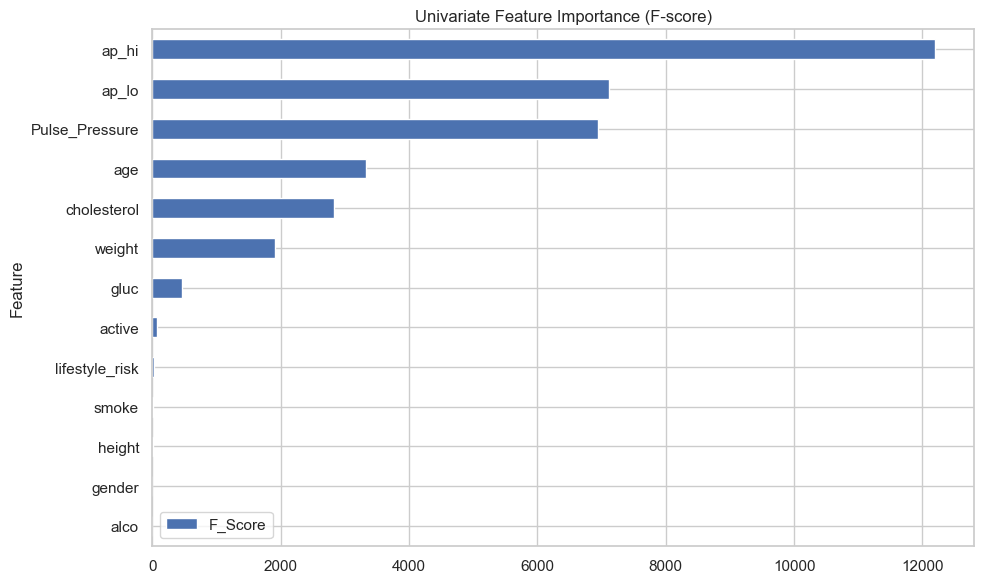

In [89]:
scores.sort_values(by='F_Score', ascending=True).plot.barh(x='Feature', y='F_Score', figsize=(10,6))
plt.title("Univariate Feature Importance (F-score)")
plt.tight_layout()
plt.show()

In [90]:
## Setup CV Variables

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
scoring = ['accuracy', 'roc_auc']

### Logistic Regression Baseline Model with and without feature engineering 
Preprocessing:
- Numeric features are scaled using StandardScaler.
- Categorical features are one-hot encoded with OneHotEncoder.

Model Training:
- Logistic Regression is trained using a pipeline with preprocessing steps.

Evaluation:
- Validation Set: Accuracy and ROC AUC are calculated.
- Cross-Validation: 5-fold CV is used to compute average accuracy and ROC AUC.
- Test Set: Final model is trained on combined training and validation data and evaluated on the test set (Accuracy & ROC AUC).

**Logistic Regression Model compared without feature engineering & with feature engineering.**

**Logistic Regression Model (without Feature Engineering)**
- The model performs reasonably well, with accuracy around 0.726 across validation, cross-validation, and test sets.
- The ROC AUC scores around 0.79 suggest the model does a good job distinguishing between the two classes (cardio or no cardio).
- These results show that the model generalizes well to new data, but there's still room for improvement.

In [93]:
real_features = [
    'age','gender','height','weight',
    'ap_hi','ap_lo',
    'cholesterol','gluc',
    'smoke','alco','active'
]

X_train_real = X_train[real_features]
X_test_real  = X_test[real_features]


pipe_plain_lr = make_pipeline(
    StandardScaler(),                            
    LogisticRegression(max_iter=1000, 
                       random_state=RANDOM_STATE)
)


cv_results_plain_lr = cross_validate(
    pipe_plain_lr,
    X_train_real, y_train,
    cv=cv,
    scoring=scoring,
    return_train_score=True,
    n_jobs=6
)

stats_plain_lr = {}
for score in scoring:
    stats_plain_lr[score] = {
        'train_mean': cv_results_plain_lr[f'train_{score}'].mean(),
        'train_std':  cv_results_plain_lr[f'train_{score}'].std(),
        'test_mean':  cv_results_plain_lr[f'test_{score}'].mean(),
        'test_std':   cv_results_plain_lr[f'test_{score}'].std(),
    }

df_scores_plain_lr = pd.DataFrame.from_dict(stats_plain_lr, orient='index')
df_scores_plain_lr['Train (mean ± std)'] = df_scores_plain_lr.apply(
    lambda r: f"{r.train_mean:.3f} ± {r.train_std:.3f}", axis=1
)
df_scores_plain_lr['Validation (mean ± std)'] = df_scores_plain_lr.apply(
    lambda r: f"{r.test_mean:.3f} ± {r.test_std:.3f}", axis=1
)

print("5-fold CV results (Logistic Regression (without Feature Engineering)):")
print(df_scores_plain_lr[['Train (mean ± std)', 'Validation (mean ± std)']])

accuracy_scores_plain_lr = cv_results_plain_lr['test_accuracy']
print("\nAccuracy scores by fold:", np.round(accuracy_scores_plain_lr, 3))
best_idx_plain_lr = np.argmax(accuracy_scores_plain_lr)  
print(f"Best fold: #{best_idx_plain_lr+1} with accuracy {accuracy_scores_plain_lr[best_idx_plain_lr]:.3f}")

pipe_plain_lr.fit(X_train_real, y_train)
y_pred_plain_lr= pipe_plain_lr.predict(X_test_real)
y_prob_plain_lr = pipe_plain_lr.predict_proba(X_test_real)[:, 1]

acc_plain_lr     = accuracy_score(y_test, y_pred_plain_lr)
roc_auc_plain_lr = roc_auc_score(y_test, y_prob_plain_lr)

print(f"\nLogistic Regression (without Feature Engineering) Test Accuracy: {acc_plain_lr:.3f}")
print(f"Logistic Regression (without Feature Engineering) Test ROC AUC:  {acc_plain_lr:.3f}")

5-fold CV results (Logistic Regression (without Feature Engineering)):
         Train (mean ± std) Validation (mean ± std)
accuracy      0.728 ± 0.001           0.727 ± 0.003
roc_auc       0.791 ± 0.001           0.791 ± 0.002

Accuracy scores by fold: [0.731 0.721 0.73  0.726 0.727]
Best fold: #1 with accuracy 0.731

Logistic Regression (without Feature Engineering) Test Accuracy: 0.726
Logistic Regression (without Feature Engineering) Test ROC AUC:  0.726


**Logistic Regression Model (with Feature Engineering)**
- The model performs reasonably well, with accuracy around 72% to 73% across validation, cross-validation, and test sets.
- The ROC AUC scores around 0.79 suggest the model does a good job distinguishing between the two classes (cardio or no cardio).
- These results show that the model generalizes well to new data, but there's still room for improvement.

In [95]:
numeric_columns = X_train.select_dtypes(include=['int64']).columns.tolist()
categorical_columns = X_train.select_dtypes(include='object').columns.tolist()

pre_processor = ColumnTransformer([
    ('numeric', StandardScaler(), numeric_columns),
    ('categorical', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_columns)
], remainder='drop')

pipe_lr = make_pipeline(
    pre_processor,
    LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)
)

cv_results_lr = cross_validate(
    pipe_lr,
    X_train, y_train,
    cv=cv,
    scoring=scoring,
    return_train_score=True,
    n_jobs=6
)

stats_lr = {}
for score in scoring:
    stats_lr[score] = {
        'train_mean': cv_results_lr[f'train_{score}'].mean(),
        'train_std':  cv_results_lr[f'train_{score}'].std(),
        'test_mean':  cv_results_lr[f'test_{score}'].mean(),
        'test_std':   cv_results_lr[f'test_{score}'].std(),
    }

df_scores_lr = pd.DataFrame.from_dict(stats_lr, orient='index')
df_scores_lr['Train (mean ± std)'] = df_scores_lr.apply(
    lambda r: f"{r.train_mean:.3f} ± {r.train_std:.3f}", axis=1
)
df_scores_lr['Validation (mean ± std)'] = df_scores_lr.apply(
    lambda r: f"{r.test_mean:.3f} ± {r.test_std:.3f}", axis=1
)

print("5-fold CV results (Logistic Regression):")
print(df_scores_lr[['Train (mean ± std)', 'Validation (mean ± std)']])

accuracy_scores_lr = cv_results_lr['test_accuracy']
print("\nAccuracy scores by fold:", np.round(accuracy_scores_lr, 3))
best_idx_lr = np.argmax(accuracy_scores_lr)  
print(f"Best fold: #{best_idx_lr+1} with accuracy {accuracy_scores_lr[best_idx_lr]:.3f}")

pipe_lr.fit(X_train, y_train)
y_pred_lr = pipe_lr.predict(X_test)
y_prob_lr = pipe_lr.predict_proba(X_test)[:, 1]

acc_lr     = accuracy_score(y_test, y_pred_lr)
roc_auc_lr = roc_auc_score(y_test, y_prob_lr)

print(f"\nLogistic Regression Test Accuracy: {acc_lr:.3f}")
print(f"Logistic Regression Test ROC AUC:  {roc_auc_lr:.3f}")

5-fold CV results (Logistic Regression):
         Train (mean ± std) Validation (mean ± std)
accuracy      0.727 ± 0.001           0.726 ± 0.003
roc_auc       0.792 ± 0.001           0.792 ± 0.002

Accuracy scores by fold: [0.73  0.724 0.726 0.728 0.724]
Best fold: #1 with accuracy 0.730

Logistic Regression Test Accuracy: 0.725
Logistic Regression Test ROC AUC:  0.795


### Model Performance Summary
Overall Accuracy: 73%
- The model correctly predicted whether someone had cardiovascular disease or not 73% of the time on the test set of 13,690 people.

- The model is more precise in identifying people with cardiovascular disease (Class 1) but misses more actual cases (lower recall).
- In order to catch as many disease cases as possible, we may want to improve recall for class 1. 

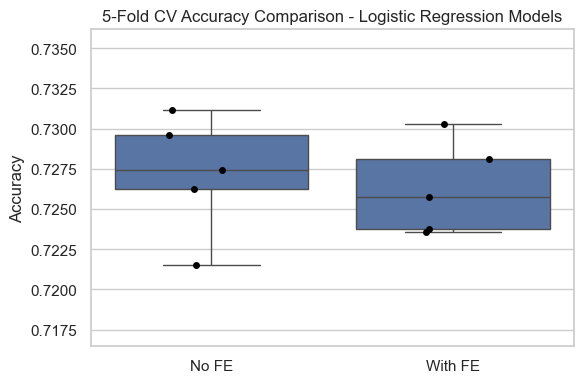

In [97]:
acc_plain = cv_results_plain_lr['test_accuracy']
acc_fe    = cv_results_lr['test_accuracy']

# build a DataFrame for Seaborn
df_acc = pd.DataFrame({
    'Accuracy': list(acc_plain) + list(acc_fe),
    'Model':    ['No FE'] * len(acc_plain) + ['With FE'] * len(acc_fe)
})

plt.figure(figsize=(6,4))
sns.boxplot(x='Model', y='Accuracy', data=df_acc)
sns.stripplot(x='Model', y='Accuracy', data=df_acc,
              color='black', size=5, jitter=0.2, dodge=True)
plt.title('5-Fold CV Accuracy Comparison - Logistic Regression Models')
plt.ylabel('Accuracy')
plt.xlabel('')
plt.ylim(df_acc.Accuracy.min() - 0.005, df_acc.Accuracy.max() + 0.005)
plt.tight_layout()
plt.show()

In [98]:
print("Classification Report for Logistic Regression:")
print(classification_report(y_test, y_pred_lr))

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.70      0.79      0.74      6922
           1       0.76      0.65      0.70      6772

    accuracy                           0.73     13694
   macro avg       0.73      0.72      0.72     13694
weighted avg       0.73      0.73      0.72     13694



### Confusion Matrix for Logistic Regression Model
**Strengths:**
- Good at identifying "Absence" cases (high TN).
- Reasonable precision for "Present" cases.

**Weaknesses:**
- Recall for "Present" is lower, meaning some actual "Present" cases are missed (FN).

The model misses quite a few actual disease cases (false negatives). This can be risky in medical screening!

Confusion Matrix for Logistic Refression Model:
[[5496 1426]
 [2338 4434]]


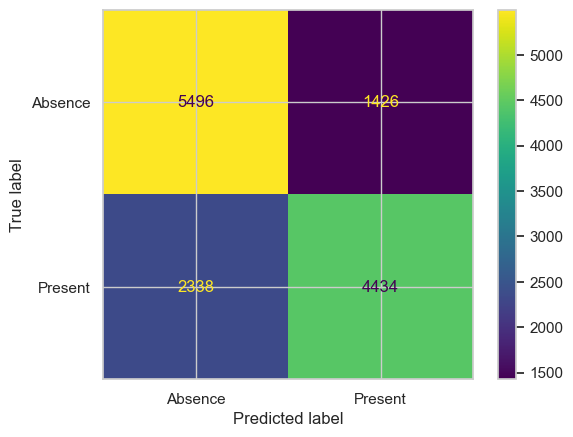

In [100]:
cm = confusion_matrix(y_test, y_pred_lr)
print("Confusion Matrix for Logistic Refression Model:")
print(cm)

ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Absence", "Present"]).plot()

### Feature Importance with Random Forest. 
This section fits a Random Forest Classifier on the training + validation data and computes feature importances. The steps include:
- Training the model to learn patterns in the data.
- Extracting true feature names (including encoded categorical features).
- Calculating each feature’s contribution to the model.
- Plotting 10 most important features based on their influence in prediction.

This analysis provides a better understanding of which features are most critical in predicting the target variable and supports data-driven decision-making.

**Conclusion:** These results suggest that body composition (height, weight, BMI), age, and blood pressure are key factors in cardiovascular prediction, aligning well with medical knowledge.

                                              Feature  Importance
3                                              weight    0.210229
2                                              height    0.201100
0                                                 age    0.185070
4                                               ap_hi    0.097799
5                                               ap_lo    0.049262
11                                     Pulse_Pressure    0.042919
6                                         cholesterol    0.041454
22  Blood_Preasure_Category_High Blood Pressure (H...    0.021832
7                                                gluc    0.020961
1                                              gender    0.018096


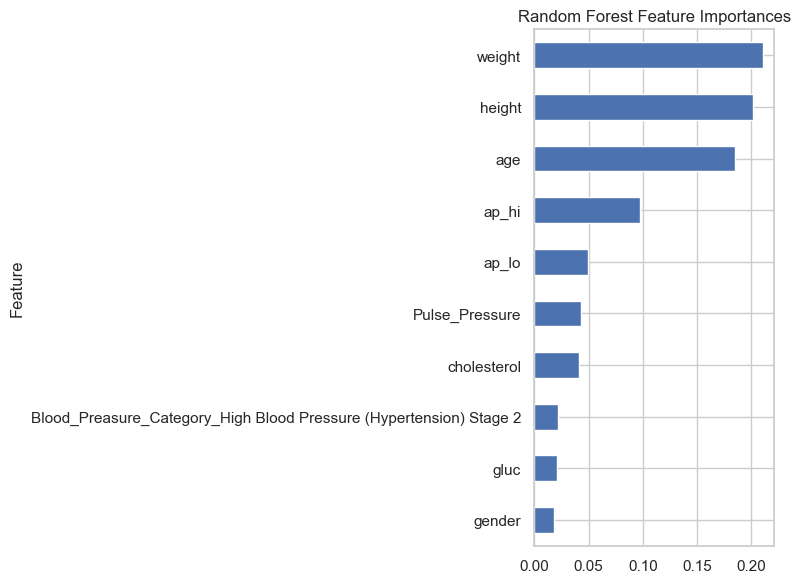

In [102]:
# multivariate feature selection

pipe_rf_mvf = make_pipeline(
    pre_processor,
    RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE)
)
pipe_rf_mvf.fit(X_train, y_train)


numeric_features = numeric_columns

ohe = pipe_rf_mvf.named_steps['columntransformer'] \
            .named_transformers_['categorical']
cat_features = list(
    ohe.get_feature_names_out(categorical_columns)
)


feature_names = numeric_features + cat_features

importances = pipe_rf_mvf.named_steps['randomforestclassifier'].feature_importances_
df_imp = pd.DataFrame({
    'Feature':    feature_names,
    'Importance': importances
}).sort_values('Importance', ascending=False)


print(df_imp.head(10))

df_imp.head(10) \
      .sort_values('Importance') \
      .plot.barh(x='Feature', y='Importance', figsize=(8,6), legend=False)
plt.title("Random Forest Feature Importances")
plt.tight_layout()
plt.show()


### Random Forest Model - Top 10 Feature Selection
1. Grid Search Results:
- Best Cross-Validation Accuracy:
The best cross-validation accuracy achieved during RandomizedSearchCV was 79.6%. This was obtained after fitting 25 different combinations of hyperparameters (5-fold cross-validation × 5 hyperparameter configurations).

- Best Hyperparameters:
    - Max Depth: 8
    - Min Samples Split: 10
    - Min Samples Leaf: 1
    - Number of Estimators: 100

2. Test Set Results:
- Test Accuracy:
The accuracy on the test set after fitting the best model was 72.9%. This is slightly higher than the average CV accuracy (69.2%), suggesting good generalization with the selected top 10 features.

- Test ROC AUC:
The ROC AUC on the test set was 0.799, indicating strong discriminatory power between the target classes, close to the model using all features.

In [104]:
sfm = SelectFromModel(
    RandomForestClassifier(random_state=RANDOM_STATE),
    max_features=10 
)

pre_processor_rf = ColumnTransformer([
    ('numeric', 'passthrough', numeric_columns),
    ('categorical',
     OneHotEncoder(drop='first', handle_unknown='ignore'),
     categorical_columns),
],
remainder='drop'  
)


pipe_rf_top10 = make_pipeline(
    pre_processor_rf,
    sfm,
    RandomForestClassifier(random_state=RANDOM_STATE) 
)

param_grid_rf_top10 = {
    'randomforestclassifier__n_estimators': [50, 100], 
    'randomforestclassifier__max_depth': [4, 8], 
    'randomforestclassifier__min_samples_split': [10],
    'randomforestclassifier__min_samples_leaf': [2]
}

cv_results_rf_top10 = cross_validate(
    pipe_rf_top10, 
    X_train, y_train,      
    cv=cv,
    scoring=scoring,
    return_train_score=True,
    n_jobs=6
)

stats_rf_top_10 = {}
for score in scoring:
    stats_rf_top_10[score] = {
        'train_mean': cv_results_rf_top10[f'train_{score}'].mean(),
        'train_std':  cv_results_rf_top10[f'train_{score}'].std(),
        'test_mean':  cv_results_rf_top10[f'test_{score}'].mean(),
        'test_std':   cv_results_rf_top10[f'test_{score}'].std(),
    }

df_scores_rf_top10 = pd.DataFrame.from_dict(stats_rf_top_10, orient='index')
df_scores_rf_top10['Train (mean ± std)'] = df_scores_rf_top10.apply(
    lambda r: f"{r.train_mean:.3f} ± {r.train_std:.3f}", axis=1
)
df_scores_rf_top10['Validation (mean ± std)'] = df_scores_rf_top10.apply(
    lambda r: f"{r.test_mean:.3f} ± {r.test_std:.3f}", axis=1
)

print("5-fold CV results (Random Forest with Top 10 Features):")
print(df_scores_rf_top10[['Train (mean ± std)', 'Validation (mean ± std)']])

accuracy_scores_rf = cv_results_rf_top10['test_accuracy']
print("\nAccuracy scores by fold:", np.round(accuracy_scores_rf, 3))
best_idx_rf = np.argmax(accuracy_scores_rf)  
print(f"Best fold: #{best_idx_rf+1} with accuracy {accuracy_scores_rf[best_idx_rf]:.3f}")


print("\nRunning RandomizedSearchCV (Random Forest - with Top 10 Features):")

random_search_rf_top10 = RandomizedSearchCV(
    pipe_rf_top10,
    param_distributions=param_grid_rf_top10,
    scoring='roc_auc',
    cv=cv,
    n_iter=4,               
    random_state=RANDOM_STATE,
    n_jobs=6,
    verbose=1
)

random_search_rf_top10 = random_search_rf_top10.fit(X_train, y_train) 
print(random_search_rf_top10.best_score_)
print(random_search_rf_top10.best_params_)
best_rf_top10_model = random_search_rf_top10.best_estimator_
y_pred_rf_top10 = best_rf_top10_model.predict(X_test)
print(f"\nRandom Forest with Top 10 Features -  Test Accuracy: {accuracy_score(y_test, y_pred_rf_top10):.3f}")
y_pred_prob_rf_top10 = best_rf_top10_model.predict_proba(X_test)[:, 1]
roc_auc_rf_top10 = roc_auc_score(y_test, y_pred_prob_rf_top10)
print(f'Random Forest with Top 10 Features - Test ROC AUC: {roc_auc_rf_top10:.3f}')

5-fold CV results (Random Forest with Top 10 Features):
         Train (mean ± std) Validation (mean ± std)
accuracy      0.959 ± 0.005           0.688 ± 0.004
roc_auc       0.994 ± 0.001           0.744 ± 0.007

Accuracy scores by fold: [0.69  0.692 0.689 0.682 0.686]
Best fold: #2 with accuracy 0.692

Running RandomizedSearchCV (Random Forest - with Top 10 Features):
Fitting 5 folds for each of 4 candidates, totalling 20 fits


/opt/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


0.7950235273423573
{'randomforestclassifier__n_estimators': 100, 'randomforestclassifier__min_samples_split': 10, 'randomforestclassifier__min_samples_leaf': 2, 'randomforestclassifier__max_depth': 8}

Random Forest with Top 10 Features -  Test Accuracy: 0.724
Random Forest with Top 10 Features - Test ROC AUC: 0.790


In [105]:
random_search_rf_top10 = random_search_rf_top10.fit(X_train, y_train)
best = random_search_rf_top10.best_estimator_

cv_score   = random_search_rf_top10.best_score_
best_params = random_search_rf_top10.best_params_

y_pred = best.predict(X_test)
test_acc = accuracy_score(y_test, y_pred)

y_proba = best.predict_proba(X_test)[:, 1]
test_auc = roc_auc_score(y_test, y_proba)

# 2) Build a summary table
results = pd.DataFrame([{
    'Model':                'RandomForest (Top10)',
    'CV Best Score':        cv_score,
    'Test Accuracy':        test_acc,
    'Test ROC AUC':         test_auc,
    'Best Params':          best_params
}])

display(
    results
      .style
      .format({
          "CV Best Score":  "{:.3f}",
          "Test Accuracy":  "{:.1%}",
          "Test ROC AUC":   "{:.3f}"
      })
      .set_caption("RandomForest with top 10 features")
)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


/opt/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


,Model,CV Best Score,Test Accuracy,Test ROC AUC,Best Params
0,RandomForest (Top10),0.795,72.4%,0.790,"{'randomforestclassifier__n_estimators': 100, 'randomforestclassifier__min_samples_split': 10, 'randomforestclassifier__min_samples_leaf': 2, 'randomforestclassifier__max_depth': 8}"


### Random Forest Model - All Features Selected 
1. Grid Search Results:
- Best Cross-Validation Accuracy:
The best cross-validation accuracy achieved during RandomizedSearchCV was 79.7%. This was obtained after fitting 25 different combinations of hyperparameters (5-fold cross-validation × 5 hyperparameter configurations).

- Best Hyperparameters:
    - Max Depth: 12
    - Min Samples Split: 10
    - Min Samples Leaf: 1
    - Number of Estimators: 50

2. Test Set Results:
- Test Accuracy:
The accuracy on the test set after fitting the best model was 73.4%. This indicates reasonably good generalization performance, slightly better than the average CV accuracy (70.2%).

- Test ROC AUC:
The ROC AUC on the test set was 0.802, indicating strong discriminatory power between the two target classes.

In [107]:
pipe_rf = make_pipeline(
    pre_processor_rf,
    RandomForestClassifier(random_state=RANDOM_STATE))

param_grid_rf = {
    'randomforestclassifier__n_estimators': [50, 100], 
    'randomforestclassifier__max_depth': [4, 8], 
    'randomforestclassifier__min_samples_split': [4],
    'randomforestclassifier__min_samples_leaf': [2],
}

cv_results_rf = cross_validate(
    pipe_rf,     
    X_train, y_train,
    cv=cv,
    scoring=scoring,
    return_train_score=True,
    n_jobs=6
)

stats_rf = {}
for score in scoring:
    stats_rf[score] = {
        'train_mean': cv_results_rf[f'train_{score}'].mean(),
        'train_std':  cv_results_rf[f'train_{score}'].std(),
        'test_mean':  cv_results_rf[f'test_{score}'].mean(),
        'test_std':   cv_results_rf[f'test_{score}'].std(),
    }

df_scores_rf = pd.DataFrame.from_dict(stats_rf, orient='index')
df_scores_rf['Train (mean ± std)'] = df_scores_rf.apply(
    lambda r: f"{r.train_mean:.3f} ± {r.train_std:.3f}", axis=1
)
df_scores_rf['Validation (mean ± std)'] = df_scores_rf.apply(
    lambda r: f"{r.test_mean:.3f} ± {r.test_std:.3f}", axis=1
)

print("5-fold CV results (Random Forest - All features selected):")
print(df_scores_rf[['Train (mean ± std)', 'Validation (mean ± std)']])

accuracy_scores_rf = cv_results_rf['test_accuracy']
print("\nAccuracy scores by fold:", np.round(accuracy_scores_rf, 3))
best_idx_rf = np.argmax(accuracy_scores_rf)  
print(f"Best fold: #{best_idx_rf+1} with accuracy {accuracy_scores_rf[best_idx_rf]:.3f}")



random_search_rf = RandomizedSearchCV(
    pipe_rf,
    param_distributions=param_grid_rf,
    scoring='roc_auc',
    cv=cv,
    n_iter=4,               
    random_state=RANDOM_STATE,
    n_jobs=6,
    verbose=1
)

random_search_rf = random_search_rf.fit(X_train, y_train)
print(random_search_rf.best_score_)
print("Best params:", random_search_rf.best_params_)

best_rf_model = random_search_rf.best_estimator_
y_pred_rf = best_rf_model.predict(X_test)
print(f"\nRandom Forest Test Accuracy: {accuracy_score(y_test, y_pred_rf):.3f}")
y_pred_prob_rf = best_rf_model.predict_proba(X_test)[:, 1]
roc_auc_rf  = roc_auc_score(y_test, y_pred_prob_rf)
print(f'Random Forest Test ROC AUC: {roc_auc_rf:.3f}')

5-fold CV results (Random Forest - All features selected):
         Train (mean ± std) Validation (mean ± std)
accuracy      0.983 ± 0.000           0.701 ± 0.002
roc_auc       0.999 ± 0.000           0.758 ± 0.001

Accuracy scores by fold: [0.703 0.702 0.699 0.703 0.697]
Best fold: #1 with accuracy 0.703
Fitting 5 folds for each of 4 candidates, totalling 20 fits
0.7962016264270002
Best params: {'randomforestclassifier__n_estimators': 100, 'randomforestclassifier__min_samples_split': 4, 'randomforestclassifier__min_samples_leaf': 2, 'randomforestclassifier__max_depth': 8}

Random Forest Test Accuracy: 0.728
Random Forest Test ROC AUC: 0.800


In [108]:
random_search_rf = random_search_rf.fit(X_train, y_train)
best = random_search_rf.best_estimator_

cv_score   = random_search_rf.best_score_
best_params = random_search_rf.best_params_

y_pred = best.predict(X_test)
test_acc = accuracy_score(y_test, y_pred)

y_proba = best.predict_proba(X_test)[:, 1]
test_auc = roc_auc_score(y_test, y_proba)

results = pd.DataFrame([{
    'Model':                'RandomForest (AllFeatures)',
    'CV Best Score':        cv_score,
    'Test Accuracy':        test_acc,
    'Test ROC AUC':         test_auc,
    'Best Params':          best_params
}])

display(
    results
      .style
      .format({
          "CV Best Score":  "{:.3f}",
          "Test Accuracy":  "{:.1%}",
          "Test ROC AUC":   "{:.3f}"
      })
      .set_caption("Random Forest with all features")
)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


,Model,CV Best Score,Test Accuracy,Test ROC AUC,Best Params
0,RandomForest (AllFeatures),0.796,72.8%,0.800,"{'randomforestclassifier__n_estimators': 100, 'randomforestclassifier__min_samples_split': 4, 'randomforestclassifier__min_samples_leaf': 2, 'randomforestclassifier__max_depth': 8}"


In [109]:
print("Classification Report for Random Forest:")
print(classification_report(y_test, y_pred_rf))

Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.70      0.80      0.75      6922
           1       0.76      0.66      0.71      6772

    accuracy                           0.73     13694
   macro avg       0.73      0.73      0.73     13694
weighted avg       0.73      0.73      0.73     13694



### Confusion Matrix for Random Forest Model:
**Strengths:**
- Good at identifying "Absence" cases (high TN).
- Reasonable precision for "Present" cases.

**Weaknesses:**
- Recall for "Present" is lower, meaning some actual "Present" cases are missed (FN).

The model misses quite a few actual disease cases (false negatives). This can be risky in medical screening!

Confusion Matrix for Random Forest Model:
[[5522 1400]
 [2323 4449]]


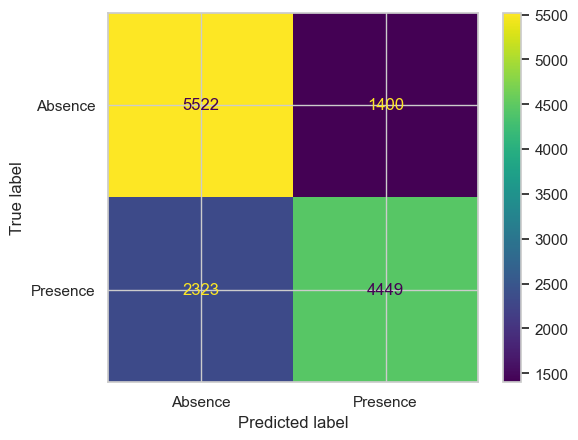

In [111]:
cm = confusion_matrix(y_test, y_pred_rf)
print("Confusion Matrix for Random Forest Model:")
print(cm)

ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Absence", "Presence"]).plot()

### K-Nearest Neighbors (KNN) Model Training & Evaluation
Summary:
- Best CV Accuracy: 0.693
- Best Parameters: n_neighbors = 9; metric = manhattan
- Test Accuracy: 0.711
- Test ROC AUC: 0.769

- The KNN model achieved modest performance, with a cross-validation accuracy of 69.3% and a slightly improved test accuracy of 71.1%. The best results were obtained using 9 neighbors and the Manhattan distance metric.
- A test ROC AUC of 0.769 indicates that the model has a fair ability to distinguish between the classes. 

In [113]:
pipe_knn = make_pipeline(pre_processor, KNeighborsClassifier())

param_grid_knn = {
    'kneighborsclassifier__n_neighbors': [3, 5, 7, 9],  
    'kneighborsclassifier__metric': ['euclidean', 'manhattan'],  }


cv_results_knn = cross_validate(
    pipe_knn,     
    X_train, y_train,
    cv=cv,
    scoring=scoring,
    return_train_score=True,
    n_jobs=6
)

stats_knn = {}
for score in scoring:
    stats_knn[score] = {
        'train_mean': cv_results_knn[f'train_{score}'].mean(),
        'train_std':  cv_results_knn[f'train_{score}'].std(),
        'test_mean':  cv_results_knn[f'test_{score}'].mean(),
        'test_std':   cv_results_knn[f'test_{score}'].std(),
    }

df_scores_knn = pd.DataFrame.from_dict(stats_knn, orient='index')
df_scores_knn['Train (mean ± std)'] = df_scores_knn.apply(
    lambda r: f"{r.train_mean:.3f} ± {r.train_std:.3f}", axis=1
)
df_scores_knn['Validation (mean ± std)'] = df_scores_knn.apply(
    lambda r: f"{r.test_mean:.3f} ± {r.test_std:.3f}", axis=1
)

print("5-fold CV results (KNN):")
print(df_scores_knn[['Train (mean ± std)', 'Validation (mean ± std)']])

accuracy_scores_knn = cv_results_knn['test_accuracy']
print("\nAccuracy scores by fold:", np.round(accuracy_scores_knn, 3))
best_idx_knn = np.argmax(accuracy_scores_knn)  
print(f"Best fold: #{best_idx_knn+1} with accuracy {accuracy_scores_knn[best_idx_knn]:.3f}")


random_search_knn = RandomizedSearchCV(
    pipe_knn, param_distributions=param_grid_knn,
    scoring='roc_auc',
    cv=cv, n_iter=4,  
    random_state=RANDOM_STATE,
    n_jobs=6, verbose=1
)


random_search_knn = random_search_knn.fit(X_train, y_train)
print(random_search_knn.best_score_)
print(random_search_knn.best_params_)
best_knn_model = random_search_knn.best_estimator_
y_pred_knn = best_knn_model.predict(X_test)
print(f"\nKNN Accuracy: {accuracy_score(y_test, y_pred_knn):.3f}")
y_pred_prob_knn = best_knn_model.predict_proba(X_test)[:, 1]
roc_auc_knn = roc_auc_score(y_test, y_pred_prob_knn)
print(f'KNN Test ROC AUC: {roc_auc_knn:.3f}')

5-fold CV results (KNN):
         Train (mean ± std) Validation (mean ± std)
accuracy      0.785 ± 0.000           0.693 ± 0.003
roc_auc       0.869 ± 0.001           0.740 ± 0.003

Accuracy scores by fold: [0.689 0.695 0.691 0.699 0.693]
Best fold: #4 with accuracy 0.699
Fitting 5 folds for each of 4 candidates, totalling 20 fits
0.7634819241618096
{'kneighborsclassifier__n_neighbors': 9, 'kneighborsclassifier__metric': 'manhattan'}

KNN Accuracy: 0.718
KNN Test ROC AUC: 0.770


### KNN Classification Report Summary
The KNN model performs fairly balanced across both classes, though with slightly better recall for class 0.

Class 0 (e.g., Absence of condition):
- Precision: 0.70 (70% of predicted 0s were correct)
- Recall: 0.74 (74% of actual 0s were correctly identified)
- F1-score: 0.72 (harmonic mean of precision and recall)

Class 1 (e.g., Presence of condition):
- Precision: 0.72
- Recall: 0.68
- F1-score: 0.70

- Overall Accuracy: 0.71
- Macro Avg F1-score: 0.71 (average performance across both classes)
- Weighted Avg F1-score: 0.71 (accounts for class imbalance)

In [115]:
print("Classification Report for KNN:")
print(classification_report(y_test, y_pred_knn))

Classification Report for KNN:
              precision    recall  f1-score   support

           0       0.71      0.75      0.73      6922
           1       0.73      0.69      0.71      6772

    accuracy                           0.72     13694
   macro avg       0.72      0.72      0.72     13694
weighted avg       0.72      0.72      0.72     13694



### Confusion Matrix Summary – KNN Model
- The model leans slightly toward predicting class 0, with more true negatives than true positives.
- False negatives (FN = 2142) are relatively high, indicating the model sometimes misses identifying class 1 (e.g., presence of condition).
- False positives (FP = 1822) are also notable but slightly lower than FN.
- Overall, performance is balanced, but the model could benefit from improved sensitivity to class 1 without significantly increasing false positives.

Confusion Matrix for KNN Model:
[[5162 1760]
 [2103 4669]]


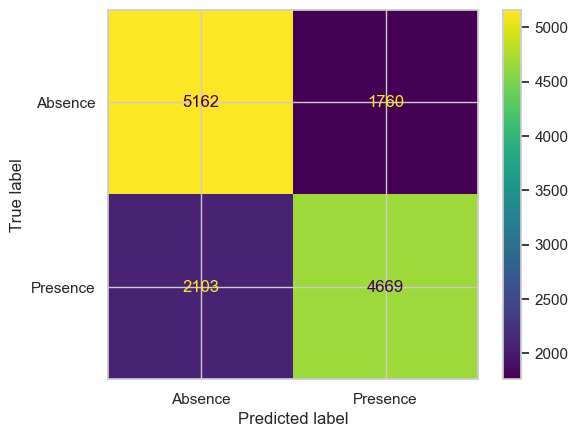

In [117]:
cm = confusion_matrix(y_test, y_pred_knn)
print("Confusion Matrix for KNN Model:")
print(cm)

ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Absence", "Presence"]).plot()

### Decision Tree Classifier: Model Training & Evaluation

**Pipeline Setup:**
- Includes preprocessing (scaling and encoding) and a DecisionTreeClassifier.

**Hyperparameter Tuning with Grid Search:**
Tested combinations of:
- max_depth: 5
- min_samples_split: 10
- min_samples_leaf: 10
- max_leaf_nodes: 10
- max_features: 0.5
- min_impurity_decrease: 0.001
- class_weight: 'balanced'
- Used 5-fold cross-validation to select the best parameters based on ROC AUC.

**Model Evaluation:**
Selected best model and evaluated it on the test set using accuracy and ROC AUC.

Key Takeaway:
- The Decision Tree model achieved a test ROC AUC of 0.784, showing solid performance in distinguishing between classes.
- Its test accuracy of 72.9% is notably higher than its average CV accuracy (62.8%), suggesting it may generalize better than expected despite relatively weak cross-validation performance.
- Overall, the model benefits from regularization and class balancing but may still be outperformed by more complex models like Random Forest or SVM.

In [119]:
pre_processor_dt = ColumnTransformer([
    ('numeric', 'passthrough', numeric_columns),
    ('categorical',
     OneHotEncoder(drop='first', handle_unknown='ignore'),
     categorical_columns),
],
remainder='drop'  
)

pipe_dt = make_pipeline(pre_processor_dt, DecisionTreeClassifier(random_state=RANDOM_STATE))

param_grid_dt = {
    'decisiontreeclassifier__max_depth': [5, 10],
    'decisiontreeclassifier__min_samples_split': [2, 10],
    'decisiontreeclassifier__min_samples_leaf': [1, 10],
    'decisiontreeclassifier__max_leaf_nodes': [10, 20],
    'decisiontreeclassifier__max_features': ['sqrt', 0.5],
    'decisiontreeclassifier__min_impurity_decrease': [0.001, 0.01],
    'decisiontreeclassifier__class_weight': ['balanced', None],
}

cv_results_dt = cross_validate(
    pipe_dt,     
    X_train, y_train,
    cv=cv,
    scoring=scoring,
    return_train_score=True,
    n_jobs=6
)

stats_dt = {}
for score in scoring:
    stats_dt[score] = {
        'train_mean': cv_results_dt[f'train_{score}'].mean(),
        'train_std':  cv_results_dt[f'train_{score}'].std(),
        'test_mean':  cv_results_dt[f'test_{score}'].mean(),
        'test_std':   cv_results_dt[f'test_{score}'].std(),
    }

df_scores_dt = pd.DataFrame.from_dict(stats_dt, orient='index')
df_scores_dt['Train (mean ± std)'] = df_scores_dt.apply(
    lambda r: f"{r.train_mean:.3f} ± {r.train_std:.3f}", axis=1
)
df_scores_dt['Validation (mean ± std)'] = df_scores_dt.apply(
    lambda r: f"{r.test_mean:.3f} ± {r.test_std:.3f}", axis=1
)

print("5-fold CV results (DecisionTree):")
print(df_scores_dt[['Train (mean ± std)', 'Validation (mean ± std)']])

accuracy_scores_dt = cv_results_dt['test_accuracy']
print("\nAccuracy scores by fold:", np.round(accuracy_scores_dt, 3))
best_idx_dt = np.argmax(accuracy_scores_dt)  
print(f"Best fold: #{best_idx_dt+1} with accuracy {accuracy_scores_dt[best_idx_dt]:.3f}")

random_search_dt = RandomizedSearchCV(
    pipe_dt, 
    param_distributions=param_grid_dt, 
    scoring='roc_auc',  
    cv=cv, n_iter=4, 
    random_state=RANDOM_STATE,
    n_jobs=6, 
    verbose=1
)


random_search_dt = random_search_dt.fit(X_train, y_train)
print(random_search_dt.best_score_)
print(random_search_dt.best_params_)
best_dt_model = random_search_dt.best_estimator_
y_pred_dt = best_dt_model.predict(X_test)
print(f"\nDecisionTree Test Accuracy: {accuracy_score(y_test, y_pred_dt):.3f}")
y_pred_prob_dt = best_dt_model.predict_proba(X_test)[:, 1]
roc_auc_dt= roc_auc_score(y_test, y_pred_prob_dt)
print(f'DecisionTree Test ROC AUC: {roc_auc_dt:.3f}')

5-fold CV results (DecisionTree):
         Train (mean ± std) Validation (mean ± std)
accuracy      0.983 ± 0.000           0.631 ± 0.002
roc_auc       0.999 ± 0.000           0.631 ± 0.001

Accuracy scores by fold: [0.632 0.628 0.634 0.629 0.63 ]
Best fold: #3 with accuracy 0.634
Fitting 5 folds for each of 4 candidates, totalling 20 fits
0.7791611993587726
{'decisiontreeclassifier__min_samples_split': 10, 'decisiontreeclassifier__min_samples_leaf': 10, 'decisiontreeclassifier__min_impurity_decrease': 0.001, 'decisiontreeclassifier__max_leaf_nodes': 10, 'decisiontreeclassifier__max_features': 0.5, 'decisiontreeclassifier__max_depth': 5, 'decisiontreeclassifier__class_weight': 'balanced'}

DecisionTree Test Accuracy: 0.725
DecisionTree Test ROC AUC: 0.785


### Decision Tree Classification Report
- Overall Accuracy: 73%
- Macro Avg F1-score: 73%
- Weighted Avg F1-score: 73%

- Class 0 (Absence) shows slightly better recall (75%)—the model is relatively strong at correctly identifying negatives.
- Class 1 (Presence) has equal precision (73%) but slightly lower recall (71%)—suggesting some false negatives.
- Performance is balanced across both classes, with consistent precision, recall, and F1-scores.
- Accuracy and F1-scores align well with the earlier ROC AUC result, indicating stable model behavior.

In [121]:
print("Classification Report for DecisionTree:")
print(classification_report(y_test, y_pred_dt))

Classification Report for DecisionTree:
              precision    recall  f1-score   support

           0       0.71      0.78      0.74      6922
           1       0.75      0.67      0.71      6772

    accuracy                           0.72     13694
   macro avg       0.73      0.72      0.72     13694
weighted avg       0.73      0.72      0.72     13694



### Decision Tree Model Confusion Matrix
- The model misses a notable number of true cases (false negatives: 1947), though less than some earlier models.
- It performs slightly better at identifying absences (class 0) than presences (class 1), as seen in the higher true negatives (5162).
- False positives (1760) are also present but reasonably controlled, suggesting balanced but not optimized sensitivity.
- Compared to models like Logistic Regression or SVM, this Decision Tree offers a simpler, interpretable structure but may slightly sacrifice recall for class 1 in favor of overall balance.

Confusion Matrix for DecisionTree Model:
[[5387 1535]
 [2237 4535]]


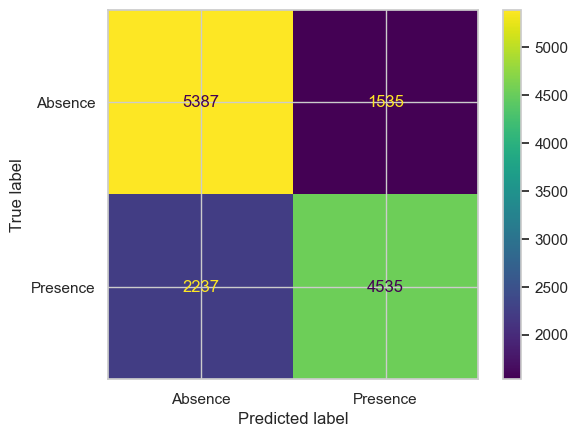

In [123]:
cm = confusion_matrix(y_test, y_pred_dt)
print("Confusion Matrix for DecisionTree Model:")
print(cm)

ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Absence", "Presence"]).plot()

### XGBoost Classifier: Model Training & Evaluation
**Evaluation Results:**
- Test Accuracy: 0.736
- ROC AUC Score: 0.805
- The model demonstrates strong predictive performance, particularly in ROC AUC, indicating excellent ability to distinguish between the two classes.
- Its accuracy is among the highest of all models tested, and the ROC AUC is the best overall, suggesting XGBoost is well-suited for this classification task.

In [125]:
pre_processor_xgb = ColumnTransformer([
    ('num', StandardScaler(), numeric_columns),
    ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore'),
            categorical_columns)
], remainder='drop')


X_train_xgb = pre_processor.fit_transform(X_train)
dtrain_xgb  = xgb.DMatrix(X_train_xgb, label=y_train)

params_xgb = {
    'objective':   'binary:logistic',
    'max_depth':   4,
    'eta':         0.1,
    'eval_metric': 'logloss',
    'seed':        RANDOM_STATE,
}
cv_result_xgb = xgb.cv(
    params_xgb,
    dtrain_xgb,
    num_boost_round=2000,
    nfold=5,
    early_stopping_rounds=10,
    seed=RANDOM_STATE,
    verbose_eval=False
)
best_nrounds_xgb = len(cv_result_xgb)
print(f"Best number of boosting rounds: {best_nrounds_xgb}")

pipe_xgb = make_pipeline(
    pre_processor_xgb, 
    XGBClassifier(
        objective='binary:logistic',
        n_estimators=best_nrounds_xgb,
        max_depth=4,
        learning_rate=0.1,
        eval_metric='logloss',
        random_state=RANDOM_STATE
    )
)

cv_res_pipe = cross_validate(
    pipe_xgb,
    X_train, y_train,
    cv=cv,
    scoring=scoring,
    return_train_score=True,
    n_jobs=6
)

stats_xgb = {}
for score in scoring:
    stats_xgb[score] = {
        'train_mean': cv_res_pipe[f'train_{score}'].mean(),
        'train_std':  cv_res_pipe[f'train_{score}'].std(),
        'test_mean':  cv_res_pipe[f'test_{score}'].mean(),
        'test_std':   cv_res_pipe[f'test_{score}'].std(),
    }

df_scores_xgb = pd.DataFrame.from_dict(stats_xgb, orient='index')
df_scores_xgb['Train (mean ± std)'] = df_scores_xgb.apply(
    lambda r: f"{r.train_mean:.3f} ± {r.train_std:.3f}", axis=1
)
df_scores_xgb['Validation (mean ± std)'] = df_scores_xgb.apply(
    lambda r: f"{r.test_mean:.3f} ± {r.test_std:.3f}", axis=1
)

print("5-fold CV results (XGBoost):")
print(df_scores_xgb[['Train (mean ± std)', 'Validation (mean ± std)']])

accuracy_scores_xgb = cv_res_pipe['test_accuracy']
print("\nAccuracy scores by fold:", np.round(accuracy_scores_xgb, 3))
best_idx_xgb = np.argmax(accuracy_scores_xgb)
print(f"Best fold: #{best_idx_xgb+1} with accuracy {accuracy_scores_xgb[best_idx_xgb]:.3f}")

pipe_xgb.fit(X_train, y_train)
y_pred_xgb = pipe_xgb.predict(X_test)
y_pred_prob_xgb = pipe_xgb.predict_proba(X_test)[:, 1]


roc_auc_xgb = roc_auc_score(y_test, y_pred_prob_xgb)


print(f"\nXGB Test Accuracy: {accuracy_score(y_test, y_pred_xgb):.3f}")
print(f"XGB Test ROC AUC : {roc_auc_score(y_test, y_pred_prob_xgb):.3f}")


Best number of boosting rounds: 71
5-fold CV results (XGBoost):
         Train (mean ± std) Validation (mean ± std)
accuracy      0.739 ± 0.001           0.735 ± 0.004
roc_auc       0.809 ± 0.000           0.801 ± 0.002

Accuracy scores by fold: [0.744 0.732 0.733 0.735 0.733]
Best fold: #1 with accuracy 0.744

XGB Test Accuracy: 0.736
XGB Test ROC AUC : 0.805


### XGBoost Classification Report
- Overall Accuracy: 74%
- Macro Avg F1-score: 74%
- Weighted Avg F1-score: 74%
- Class 0 (Absence) shows better recall (78%)—indicating strong performance in identifying negatives.
- Class 1 (Presence) has slightly higher precision (76%)—fewer false positives, but a lower recall (69%) suggests some true cases are being missed.
- Accuracy and F1-scores are consistent with the model’s high ROC AUC (0.805), confirming XGBoost as one of the top performers in this evaluation.

In [127]:
print("Classification Report for XGBoost:")
print(classification_report(y_test, y_pred_xgb))

Classification Report for XGBoost:
              precision    recall  f1-score   support

           0       0.72      0.78      0.75      6922
           1       0.76      0.69      0.72      6772

    accuracy                           0.74     13694
   macro avg       0.74      0.73      0.73     13694
weighted avg       0.74      0.74      0.73     13694



### XGBoost Model Confusion Matrix
- The model misses a fair number of true cases (false negatives: 2113), though its overall balance remains solid.
- It performs better at identifying absences (class 0), as indicated by a high number of true negatives (5425).
- False positives (1497) are relatively well-controlled, showing the model is conservative in misclassifying positives.
- Compared to models like Decision Tree or KNN, XGBoost demonstrates stronger overall balance, with a slight trade-off in recall for class 1 but gains in precision and overall robustness.

Confusion Matrix for XGBoost model:
[[5419 1503]
 [2119 4653]]


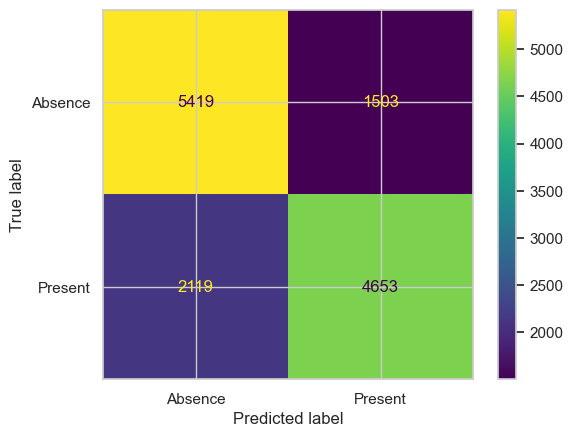

In [129]:
cm = confusion_matrix(y_test, y_pred_xgb)
print("Confusion Matrix for XGBoost model:")
print(cm)

ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Absence", "Present"]).plot()

### Catboost Classifier: Model Training & Evaluation
The model shows strong and consistent performance, with both high accuracy and ROC AUC scores, making it one of the top-performing models evaluated.
- Accuracy is relatively high and in line with the best models like XGBoost and Random Forest.
- ROC AUC indicates the model has excellent ability to distinguish between the two classes.
- CatBoost’s native handling of categorical features and built-in regularization contribute to its robustness and efficiency.
- Test Accuracy: 0.735
- ROC AUC Score: 0.805

In [131]:
cb_clf = CatBoostClassifier(
    random_seed=RANDOM_STATE,
    verbose=False
)
pipe_cb = make_pipeline(pre_processor, cb_clf) 

param_grid_cb = {
    'catboostclassifier__iterations'    : [1000, 2000],
    'catboostclassifier__learning_rate' : [0.01, 0.1],
    'catboostclassifier__depth'         : [4],
    'catboostclassifier__l2_leaf_reg'   : [1, 3, 5],
    'catboostclassifier__subsample'     : [0.7, 0.9],
}

cv_results_cb = cross_validate(
    pipe_cb,
    X_train, y_train,
    cv=cv,                       
    scoring=scoring,
    return_train_score=True,
    n_jobs=6
)

stats_cb = {}
for score in scoring:
    stats_cb[score] = {
        'train_mean': cv_results_cb[f'train_{score}'].mean(),
        'train_std':  cv_results_cb[f'train_{score}'].std(),
        'test_mean':  cv_results_cb[f'test_{score}'].mean(),
        'test_std':   cv_results_cb[f'test_{score}'].std(),
    }

df_scores_cb = pd.DataFrame.from_dict(stats_cb, orient='index')
df_scores_cb['Train (mean ± std)'] = df_scores_cb.apply(
    lambda r: f"{r.train_mean:.3f} ± {r.train_std:.3f}", axis=1
)
df_scores_cb['Validation (mean ± std)'] = df_scores_cb.apply(
    lambda r: f"{r.test_mean:.3f} ± {r.test_std:.3f}", axis=1
)

print("5-fold CV results (CatBoost):")
print(df_scores_cb[['Train (mean ± std)', 'Validation (mean ± std)']])

accuracy_scores_cb = cv_results_cb['test_accuracy']
print("\nAccuracy scores by fold:", np.round(accuracy_scores_cb, 3))

best_idx_cb   = np.argmax(accuracy_scores_cb)
best_score_cb = accuracy_scores_cb[best_idx_cb]
print(f"Best fold: #{best_idx_cb+1} with accuracy {best_score_cb:.3f}")

random_search_cb = RandomizedSearchCV(
    pipe_cb,
    param_distributions=param_grid_cb,
    scoring='roc_auc',
    cv=cv, n_iter=4, 
    random_state=RANDOM_STATE,
    n_jobs=6,
    verbose=1
)

random_search_cb.fit(X_train, y_train)
print("\nBest CV ROC AUC:", random_search_cb.best_score_)
print("Best params:      ", random_search_cb.best_params_)

best_cb_model = random_search_cb.best_estimator_
y_pred_cb = best_cb_model.predict(X_test)
y_pred_prob_cb  = best_cb_model.predict_proba(X_test)[:, 1]

roc_auc_cb = roc_auc_score(y_test, y_pred_prob_cb)

print(f"\nCatBoost Test Accuracy : {accuracy_score(y_test, y_pred_cb):.3f}")
print(f"CatBoost Test ROC AUC  : {roc_auc_cb:.3f}")


5-fold CV results (CatBoost):
         Train (mean ± std) Validation (mean ± std)
accuracy      0.758 ± 0.001           0.733 ± 0.003
roc_auc       0.835 ± 0.000           0.799 ± 0.001

Accuracy scores by fold: [0.739 0.73  0.73  0.733 0.732]
Best fold: #1 with accuracy 0.739
Fitting 5 folds for each of 4 candidates, totalling 20 fits


/opt/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



Best CV ROC AUC: 0.8009918841065999
Best params:       {'catboostclassifier__subsample': 0.7, 'catboostclassifier__learning_rate': 0.01, 'catboostclassifier__l2_leaf_reg': 3, 'catboostclassifier__iterations': 2000, 'catboostclassifier__depth': 4}

CatBoost Test Accuracy : 0.735
CatBoost Test ROC AUC  : 0.805


,Accuracy,Test ROC AUC
Model,,
XGBoost,73.6%,0.805
CatBoost,73.5%,0.805
RandomForest,72.8%,0.800


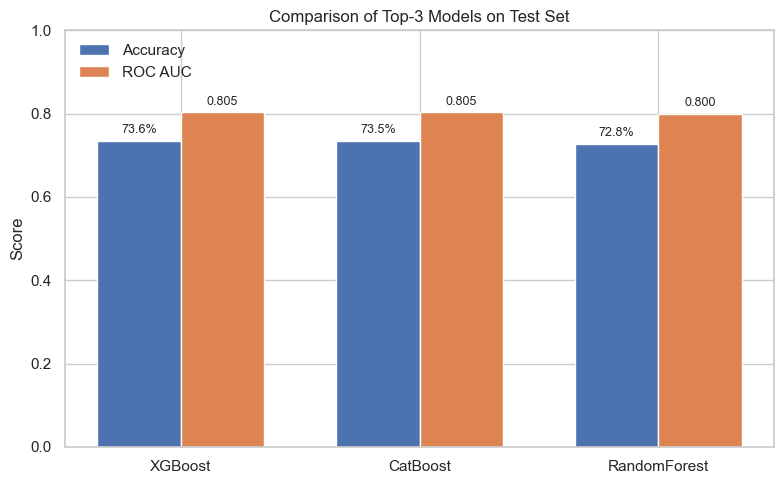

In [132]:
metrics = []

# 1) XGBoost
metrics.append({
    "Model":        "XGBoost",
    "Accuracy":     accuracy_score(y_test, y_pred_xgb),
    "Test ROC AUC": roc_auc_score(y_test, y_pred_prob_xgb)
})

# 2) CatBoost
metrics.append({
    "Model":        "CatBoost",
    "Accuracy":     accuracy_score(y_test, y_pred_cb),
    "Test ROC AUC": roc_auc_score(y_test, y_pred_prob_cb)
})

# 3) RandomForest
metrics.append({
    "Model":        "RandomForest",
    "Accuracy":     accuracy_score(y_test, y_pred_rf),
    "Test ROC AUC": roc_auc_score(y_test, y_pred_prob_rf)
})

df_metrics = pd.DataFrame(metrics)
display(
    df_metrics.set_index("Model")
      .style
      .format({
          "Accuracy":     "{:.1%}",
          "Test ROC AUC": "{:.3f}"
      })
      .set_caption("Top-3 Model Test Metrics")
)

models = df_metrics["Model"].tolist()
accs   = df_metrics["Accuracy"].values
rocs   = df_metrics["Test ROC AUC"].values

x     = np.arange(len(models))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 5))
bars1 = ax.bar(x - width/2, accs, width, label="Accuracy")
bars2 = ax.bar(x + width/2, rocs, width, label="ROC AUC")

for bar, val in zip(bars1, accs):
    ax.text(bar.get_x() + bar.get_width()/2,
            bar.get_height() + 0.01,
            f"{val:.1%}",
            ha="center", va="bottom", fontsize=9)
for bar, val in zip(bars2, rocs):
    ax.text(bar.get_x() + bar.get_width()/2,
            bar.get_height() + 0.01,
            f"{val:.3f}",
            ha="center", va="bottom", fontsize=9)

ax.legend(loc="upper left", frameon=False)
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.set_ylim(0, 1)
ax.set_ylabel("Score")
ax.set_title("Comparison of Top-3 Models on Test Set")
plt.tight_layout()
plt.show()


### CatBoost Classification Report
- Overall Accuracy: 74%
- Macro Avg F1-score: 73%
- Weighted Avg F1-score: 73%
- Class 0 (Absence) shows better recall (78%)—indicating strong performance in identifying negatives.
- Class 1 (Presence) has slightly higher precision (75%)—fewer false positives, but a lower recall (69%) suggests some true cases are being missed.
- Accuracy and F1-scores are consistent with the model’s high ROC AUC (0.805), confirming XGBoost as one of the top performers in this evaluation.

In [134]:
print("Classification Report for CatBoost:")
print(classification_report(y_test, y_pred_cb))

Classification Report for CatBoost:
              precision    recall  f1-score   support

           0       0.72      0.78      0.75      6922
           1       0.76      0.69      0.72      6772

    accuracy                           0.74     13694
   macro avg       0.74      0.73      0.73     13694
weighted avg       0.74      0.74      0.73     13694



### CatBoost Model Confusion Matrix
- The model misses a notable number of true cases (false negatives: 2105), though it maintains a good balance overall.
- It performs better at identifying absences (class 0), as seen by the higher number of true negatives (5402).
- False positives (1520) are well-managed, indicating the model is conservative in misclassifying positive cases.
- Compared to other models like Decision Tree or KNN, CatBoost demonstrates a strong balance with a slight trade-off in recall for class 1, but gains in precision and overall robustness.

Confusion Matrix for CatBoost model:
[[5410 1512]
 [2112 4660]]


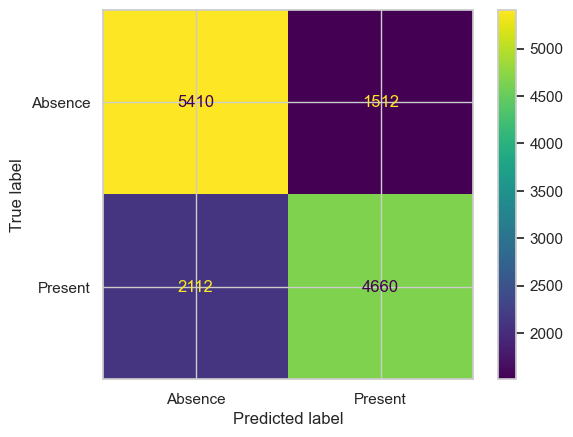

In [136]:
cm = confusion_matrix(y_test, y_pred_cb)
print("Confusion Matrix for CatBoost model:")
print(cm)

ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Absence", "Present"]).plot()

### Model Comparison and Evaluation
Below we have compiled the performance of multiple machine learning models on a classification task. The models are evaluated across various metrics, including accuracy, precision, recall (sensitivity), F1 score, and specificity. The results are visualized using a grouped bar chart, and a summary table is displayed showing each model's performance in percentage format.

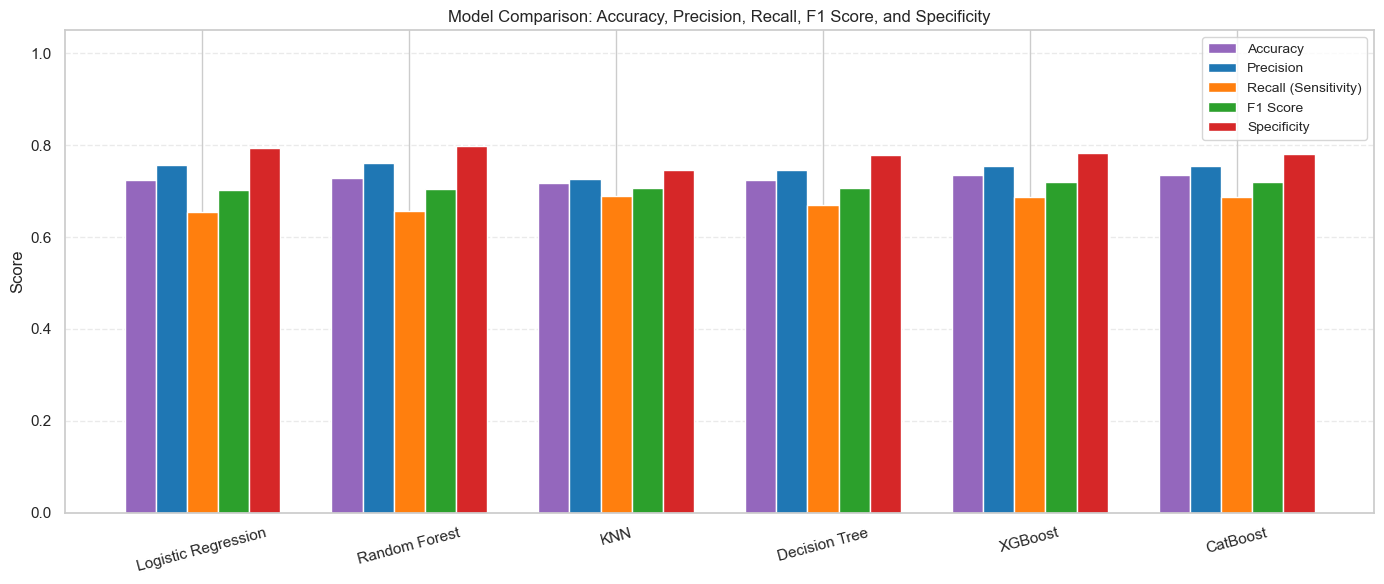

,Model,Accuracy,Precision,Recall (Sensitivity),F1 Score,Specificity
0,KNN,71.8%,72.6%,68.9%,70.7%,74.6%
1,CatBoost,73.5%,75.5%,68.8%,72.0%,78.2%
2,XGBoost,73.6%,75.6%,68.7%,72.0%,78.3%
3,Decision Tree,72.5%,74.7%,67.0%,70.6%,77.8%
4,Random Forest,72.8%,76.1%,65.7%,70.5%,79.8%
5,Logistic Regression,72.5%,75.7%,65.5%,70.2%,79.4%


In [138]:
# Model names and predictions

models = ["Logistic Regression", "Random Forest", "KNN", "Decision Tree", "XGBoost", "CatBoost"]
preds = [y_pred_lr, y_pred_rf, y_pred_knn, y_pred_dt, y_pred_xgb, y_pred_cb]

# Metric calculations
accuracies = [accuracy_score(y_test, y_pred) for y_pred in preds]
precisions = [precision_score(y_test, y_pred) for y_pred in preds]
recalls = [recall_score(y_test, y_pred) for y_pred in preds]
f1s = [f1_score(y_test, y_pred) for y_pred in preds]

def compute_specificity(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn + fp)

specificities = [compute_specificity(y_test, y_pred) for y_pred in preds]

metrics = [accuracies, precisions, recalls, f1s, specificities]
metric_names = ["Accuracy", "Precision", "Recall (Sensitivity)", "F1 Score", "Specificity"]
colors = ["#9467bd", "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"]  #

x = np.arange(len(models))
width = 0.15

plt.figure(figsize=(14, 6))
for i in range(len(metrics)):
    offset = (i - 2) * width  
    plt.bar(x + offset, metrics[i], width=width, label=metric_names[i], color=colors[i])

plt.xticks(ticks=x, labels=models, rotation=15)
plt.ylim(0, 1.05)
plt.ylabel("Score")
plt.title("Model Comparison: Accuracy, Precision, Recall, F1 Score, and Specificity")
plt.legend(loc="upper right", fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

summary_table = pd.DataFrame({
    "Model": models,
    "Accuracy": accuracies,
    "Precision": precisions,
    "Recall (Sensitivity)": recalls,
    "F1 Score": f1s,
    "Specificity": specificities
}).sort_values(by="Recall (Sensitivity)", ascending=False).reset_index(drop=True)

display(
    summary_table.style.format({
        "Accuracy": "{:.1%}",
        "Precision": "{:.1%}",
        "Recall (Sensitivity)": "{:.1%}",
        "F1 Score": "{:.1%}",
        "Specificity": "{:.1%}"
    }).set_caption("Model Evaluation Metrics Scores")
)


### ROC Curve and AUC Comparison Across Models
This section of the analysis focuses on evaluating the classification performance of various machine learning models using **ROC (Receiver Operating Characteristic) curves** and **AUC (Area Under the Curve)** scores. These tools help assess a model's ability to distinguish between the two classes.

Models evaluated:
- Logistic Regression : AUC = 0.795
- Random Forest: AUC = 0.803
- K-Nearest Neighbors (KNN): AUC = 0.769
- Decision Tree: AUC = 0.784
- XGBoost: AUC = 0.805
- CatBoost: AUC = 0.805

**The ROC curve comparison highlights the relative strengths of each model, with CatBoost and XGBoost performing best in terms of AUC.**


In [140]:
# ACCURACY SCORES 
acc_lr = accuracy_score(y_test, y_pred_lr)
acc_rf = accuracy_score(y_test, y_pred_rf)
acc_knn = accuracy_score(y_test, y_pred_knn)
acc_dt = accuracy_score(y_test, y_pred_dt)
acc_xgb = accuracy_score(y_test, y_pred_xgb)
acc_cb = accuracy_score(y_test, y_pred_cb)

# ROC CURVES & AUC 
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_prob_rf)
fpr_knn, tpr_knn, _ = roc_curve(y_test, y_pred_prob_knn)
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_pred_prob_dt)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_prob_xgb)
fpr_cb, tpr_cb, _ = roc_curve(y_test, y_pred_prob_cb)

#ROC CURVE PLOT
plt.figure(figsize=(10, 7))

plt.plot(fpr_lr, tpr_lr, label=f"Logistic Regression (AUC = {roc_auc_lr:.3f})", linestyle='-', linewidth=2, color="orange")
# plt.plot(fpr_svc, tpr_svc, label=f"SVC (AUC = {roc_auc_svc:.3f})", linestyle='--', linewidth=2, color="red")
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {roc_auc_rf:.3f})", linestyle='-', linewidth=2, color="blue")
plt.plot(fpr_knn, tpr_knn, label=f"KNN (AUC = {roc_auc_knn:.3f})", linestyle='-.', linewidth=2, color="green")
plt.plot(fpr_dt, tpr_dt, label=f"Decision Tree (AUC = {roc_auc_dt:.3f})", linestyle=':', linewidth=2, color="purple")
plt.plot(fpr_xgb, tpr_xgb, label=f"XGBoost (AUC = {roc_auc_xgb:.3f})", linestyle='-', linewidth=2, color="brown")
plt.plot(fpr_cb, tpr_cb, label=f"CatBoost (AUC = {roc_auc_cb:.3f})", linestyle='-', linewidth=2, color="yellow")


plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Reference Line')

plt.title("ROC Curve Comparison Across Models", fontsize=15, fontweight="bold")
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
(plt.savefig("roc.pdf", dpi=300, format="pdf"

SyntaxError: incomplete input (2541327086.py, line 38)

### Confusion Matrix Visualization for All Models:
This section of the analysis visualizes the **confusion matrices** for all the classification models. A confusion matrix offers a detailed breakdown of model predictions, revealing the number of correct and incorrect predictions made for each class.

In [ ]:
# Predictions and names
model_preds = [
    (y_pred_lr, "Logistic Regression", "Oranges"),
    (y_pred_rf, "Random Forest", "Blues"),
    (y_pred_knn, "KNN", "Greens"),
    (y_pred_dt, "Decision Tree", "Purples"),
    (y_pred_xgb, "XGBoost", "YlGnBu"),
    (y_pred_cb, "CatBoost", "plasma")

]

fig, axes = plt.subplots(4, 2, figsize=(12, 16))
axes = axes.flatten()

for i, (y_pred, model_name, cmap_color) in enumerate(model_preds):
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=["Absence", "Presence"])
    disp.plot(cmap=cmap_color, ax=axes[i], colorbar=False)
    axes[i].set_title(model_name, fontsize=12, fontweight="bold")
    axes[i].grid(False)

axes[-1].axis('off')

plt.suptitle("Confusion Matrices by Model", fontsize=16, fontweight="bold", y=1.02)
plt.tight_layout()
plt.show()

### 3-Model Voting  & Stacking Ensemble (CatBoost + XGBoost + Random Forest)
These are combined using a Soft Voting strategy. In soft voting, each model outputs probabilities for each class, and the final prediction is based on the average of these probabilities. This often results in better-calibrated predictions compared to hard voting (which averages class labels).

Performance:
- ROC AUC Score: 0.797
- Accuracy: 0.732

- This lightweight 3-model ensemble provides solid performance, combining the strengths of CatBoost, XGBoost, and Random Forest to outperform more complex strategies in terms of both accuracy and AUC.

- A stacked ensemble of the top 3 models (CatBoost, XGBoost, and Random Forest) achieved the best overall performance with a ROC AUC of 0.805 and accuracy of 73.6%, slightly outperforming the soft voting ensemble, and showing the power of combining models to leverage their complementary strengths.

In [ ]:
estimators = [
    ('xgb', pipe_xgb),  
    ('cb',  pipe_cb),
    ('rf',  pipe_rf)
]

voting = VotingClassifier(
    estimators=estimators,
    voting='soft',
    n_jobs=6
)


voting.fit(X_train, y_train)

y_prob_v = voting.predict_proba(X_test)[:, 1]
print("Top 3 models - Soft Voting Ensemble ROC AUC:", roc_auc_score(y_test, y_prob_v))
print("Top 3 models  - Soft Voting Ensemble Accuracy:", accuracy_score(y_test, voting.predict(X_test)))

stacking = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(random_state=RANDOM_STATE),
    cv=cv,              
    n_jobs=6,
    passthrough=False    
)

stacking.fit(X_train, y_train)
y_prob_s = stacking.predict_proba(X_test)[:, 1]
print("Top 3 models - Stacked Ensemble ROC AUC:", roc_auc_score(y_test, y_prob_s))
print("Top 3 models - Stacked Ensemble Accuracy:", accuracy_score(y_test, stacking.predict(X_test)))

In [ ]:
results = [
    {
      "Model": "Soft Voting",
      "Accuracy": accuracy_score(y_test, voting.predict(X_test)),
      "ROC AUC":  roc_auc_score(y_test, y_prob_v)
    },
    {
      "Model": "Stacking",
      "Accuracy": accuracy_score(y_test, stacking.predict(X_test)),
      "ROC AUC":  roc_auc_score(y_test, y_prob_s)
    }
]
df = pd.DataFrame(results).set_index("Model")

display(
    df.style
      .format({"Accuracy":"{:.1%}", "ROC AUC":"{:.3f}"})
      .set_caption("Soft Voting vs. Stacking Comparison")
)

labels = df.index.tolist()
accs   = df["Accuracy"].values
rocs   = df["ROC AUC"].values

x     = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(6, 4))
bars1 = ax.bar(x - width/2, accs, width, label="Accuracy")
bars2 = ax.bar(x + width/2, rocs, width, label="ROC AUC")

for bar, val in zip(bars1, accs):
    ax.text(bar.get_x()+bar.get_width()/2, bar.get_height()+0.01,
            f"{val:.1%}", ha="center", va="bottom", fontsize=9)
for bar, val in zip(bars2, rocs):
    ax.text(bar.get_x()+bar.get_width()/2, bar.get_height()+0.005,
            f"{val:.3f}", ha="center", va="bottom", fontsize=9)

ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylim(0, 1)
ax.set_ylabel("Score")
ax.set_title("Soft Voting vs. Stacking Comparison")
ax.legend(frameon=False)

plt.tight_layout()
plt.show()


### Confusion Matrix -  Ensemble learning
The Voting Ensemble achieves a slightly higher number of true positives (4,692) compared to Stacking (4,685), indicating it identifies more actual positive cases. However, it also has fewer false negatives (2,080 vs. 2,087), meaning it misses slightly fewer positives. Overall, the Voting Ensemble performs marginally better in detecting true positive cases.

In [ ]:
y_pred_vote = voting.predict(X_test)
y_pred_stack = stacking.predict(X_test)
y_true = y_test.values

cm_vote = confusion_matrix(y_true, y_pred_vote)
cm_stack = confusion_matrix(y_true, y_pred_stack)

labels = ['Absence (0)', 'Presence (1)']

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

sns.heatmap(
    cm_vote, annot=True, fmt='d', cmap='Blues',
    xticklabels=labels, yticklabels=labels, ax=axes[0]
)
axes[0].set_title('Voting Ensemble')
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')

sns.heatmap(
    cm_stack, annot=True, fmt='d', cmap='Greens',
    xticklabels=labels, yticklabels=labels, ax=axes[1]
)
axes[1].set_title('Stacking Ensemble')
axes[1].set_xlabel('Predicted Label')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()